In [1]:
# Import the necessary librabries and tools
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import math
from tabulate import tabulate
from scipy.stats import shapiro, wilcoxon
from collections import defaultdict
from lifelines import KaplanMeierFitter, CoxPHFitter
from lifelines.statistics import logrank_test
from sklearn.datasets import make_regression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, roc_auc_score, precision_score, recall_score, f1_score, confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, train_test_split

## Data processing , transformation , preparation and cleaning

### Data processing

Loading my initial datasets provided by the UCSC Xena 

In [2]:
pancancer = pd.read_excel("TCGA_PanCancer_CuratedData.xlsx")

In [3]:
pancancer

,sample,_PATIENT,cancer type abbreviation,age_at_initial_pathologic_diagnosis,gender,race,ajcc_pathologic_tumor_stage,clinical_stage,histological_type,histological_grade,...,residual_tumor,OS,OS.time,DSS,DSS.time,DFI,DFI.time,PFI,PFI.time,Redaction
0,TCGA-OR-A5J1-01,TCGA-OR-A5J1,ACC,58.0,MALE,WHITE,Stage II,NaN,Adrenocortical carcinoma- Usual Type,NaN,...,NaN,1.0,1355.0,1.0,1355.0,1.0,754.0,1.0,754.0,NaN
1,TCGA-OR-A5J2-01,TCGA-OR-A5J2,ACC,44.0,FEMALE,WHITE,Stage IV,NaN,Adrenocortical carcinoma- Usual Type,NaN,...,NaN,1.0,1677.0,1.0,1677.0,NaN,NaN,1.0,289.0,NaN
2,TCGA-OR-A5J3-01,TCGA-OR-A5J3,ACC,23.0,FEMALE,WHITE,Stage III,NaN,Adrenocortical carcinoma- Usual Type,NaN,...,NaN,0.0,2091.0,0.0,2091.0,1.0,53.0,1.0,53.0,NaN
3,TCGA-OR-A5J4-01,TCGA-OR-A5J4,ACC,23.0,FEMALE,WHITE,Stage IV,NaN,Adrenocortical carcinoma- Usual Type,NaN,...,NaN,1.0,423.0,1.0,423.0,NaN,NaN,1.0,126.0,NaN
4,TCGA-OR-A5J5-01,TCGA-OR-A5J5,ACC,30.0,MALE,WHITE,Stage III,NaN,Adrenocortical carcinoma- Usual Type,NaN,...,NaN,1.0,365.0,1.0,365.0,NaN,NaN,1.0,50.0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12586,TCGA-YZ-A980-01,TCGA-YZ-A980,UVM,75.0,MALE,WHITE,Stage IIIA,Stage IIIA,Spindle Cell|Epithelioid Cell,NaN,...,NaN,0.0,1862.0,0.0,1862.0,NaN,NaN,1.0,1556.0,NaN
12587,TCGA-YZ-A982-01,TCGA-YZ-A982,UVM,79.0,FEMALE,WHITE,Stage IIIB,Stage IIIB,Spindle Cell,NaN,...,NaN,0.0,495.0,0.0,495.0,NaN,NaN,0.0,495.0,NaN
12588,TCGA-YZ-A983-01,TCGA-YZ-A983,UVM,51.0,FEMALE,WHITE,Stage IIB,Stage IIB,Epithelioid Cell,NaN,...,NaN,0.0,798.0,0.0,798.0,NaN,NaN,0.0,798.0,NaN
12589,TCGA-YZ-A984-01,TCGA-YZ-A984,UVM,50.0,FEMALE,WHITE,Stage IIB,Stage IIIA,Spindle Cell|Epithelioid Cell,NaN,...,NaN,1.0,1396.0,1.0,1396.0,NaN,NaN,1.0,154.0,NaN


In [4]:
prad_phenotype = pd.read_excel("TCGA_PRAD_Phenotypes.xlsx")

In [5]:
prad_phenotype

,sampleID,_INTEGRATION,_PATIENT,_cohort,_primary_disease,_primary_site,additional_pharmaceutical_therapy,additional_radiation_therapy,age_at_initial_pathologic_diagnosis,bcr_followup_barcode,...,_GENOMIC_ID_TCGA_PRAD_PDMRNAseq,_GENOMIC_ID_TCGA_PRAD_miRNA_HiSeq,_GENOMIC_ID_TCGA_PRAD_RPPA,_GENOMIC_ID_TCGA_PRAD_gistic2,_GENOMIC_ID_TCGA_PRAD_exp_HiSeqV2_percentile,_GENOMIC_ID_TCGA_PRAD_PDMRNAseqCNV,_GENOMIC_ID_data/public/TCGA/PRAD/miRNA_HiSeq_gene,_GENOMIC_ID_TCGA_PRAD_mutation_bcm_gene,_GENOMIC_ID_TCGA_PRAD_mutation_curated_broad_gene,_GENOMIC_ID_TCGA_PRAD_exp_HiSeqV2_PANCAN
0,TCGA-2A-A8VL-01,TCGA-2A-A8VL-01,TCGA-2A-A8VL,TCGA Prostate Cancer (PRAD),prostate adenocarcinoma,Prostate,NaN,NaN,51,TCGA-2A-A8VL-F71759,...,TCGA-2A-A8VL-01,TCGA-2A-A8VL-01,1487FD23-ED22-4942-86D6-CF19837F63B9,TCGA-2A-A8VL-01A-21D-A376-01,e10fe58f-7ceb-4ad8-bce3-5ffbefc05cb5,TCGA-2A-A8VL-01,TCGA-2A-A8VL-01,NaN,TCGA-2A-A8VL-01A-21D-A377-08,e10fe58f-7ceb-4ad8-bce3-5ffbefc05cb5
1,TCGA-2A-A8VO-01,TCGA-2A-A8VO-01,TCGA-2A-A8VO,TCGA Prostate Cancer (PRAD),prostate adenocarcinoma,Prostate,NaN,NaN,57,TCGA-2A-A8VO-F71780,...,TCGA-2A-A8VO-01,TCGA-2A-A8VO-01,FF23B458-D1F8-4001-A8E3-7F8785435C76,TCGA-2A-A8VO-01A-11D-A376-01,20a779a3-04ab-4080-b11d-ed7b22fcd2da,TCGA-2A-A8VO-01,TCGA-2A-A8VO-01,NaN,TCGA-2A-A8VO-01A-11D-A377-08,20a779a3-04ab-4080-b11d-ed7b22fcd2da
2,TCGA-2A-A8VT-01,TCGA-2A-A8VT-01,TCGA-2A-A8VT,TCGA Prostate Cancer (PRAD),prostate adenocarcinoma,Prostate,NaN,NaN,47,TCGA-2A-A8VT-F71798,...,TCGA-2A-A8VT-01,TCGA-2A-A8VT-01,931CEBFB-011C-4797-8E05-8012D3ADC601,TCGA-2A-A8VT-01A-11D-A376-01,2e80aebe-77b5-496c-bde9-494b9b94ee3f,TCGA-2A-A8VT-01,TCGA-2A-A8VT-01,NaN,TCGA-2A-A8VT-01A-11D-A377-08,2e80aebe-77b5-496c-bde9-494b9b94ee3f
3,TCGA-2A-A8VV-01,TCGA-2A-A8VV-01,TCGA-2A-A8VV,TCGA Prostate Cancer (PRAD),prostate adenocarcinoma,Prostate,NaN,NaN,52,TCGA-2A-A8VV-F71800,...,TCGA-2A-A8VV-01,TCGA-2A-A8VV-01,443A2276-226E-4D27-936C-3B25B14E7121,TCGA-2A-A8VV-01A-11D-A376-01,45eca81f-9ce2-4de6-b970-65959d76398c,TCGA-2A-A8VV-01,TCGA-2A-A8VV-01,NaN,TCGA-2A-A8VV-01A-11D-A377-08,45eca81f-9ce2-4de6-b970-65959d76398c
4,TCGA-2A-A8VX-01,TCGA-2A-A8VX-01,TCGA-2A-A8VX,TCGA Prostate Cancer (PRAD),prostate adenocarcinoma,Prostate,NaN,NaN,70,TCGA-2A-A8VX-F71804,...,TCGA-2A-A8VX-01,TCGA-2A-A8VX-01,1A003DC8-7045-4F90-A768-F2E88FE31242,TCGA-2A-A8VX-01A-11D-A376-01,0ff237d2-9283-44c7-bfae-c2020c73b94c,TCGA-2A-A8VX-01,TCGA-2A-A8VX-01,NaN,NaN,0ff237d2-9283-44c7-bfae-c2020c73b94c
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
561,TCGA-ZG-A9M4-01,TCGA-ZG-A9M4-01,TCGA-ZG-A9M4,TCGA Prostate Cancer (PRAD),prostate adenocarcinoma,Prostate,NaN,NaN,65,TCGA-ZG-A9M4-F67945,...,TCGA-ZG-A9M4-01,TCGA-ZG-A9M4-01,691D3F9B-5F1D-4D41-B54E-ECC3D69DB7C2,TCGA-ZG-A9M4-01A-11D-A41J-01,9c1dbf62-a42a-4a60-84bb-98715d9a4b60,TCGA-ZG-A9M4-01,TCGA-ZG-A9M4-01,NaN,NaN,9c1dbf62-a42a-4a60-84bb-98715d9a4b60
562,TCGA-ZG-A9MC-01,TCGA-ZG-A9MC-01,TCGA-ZG-A9MC,TCGA Prostate Cancer (PRAD),prostate adenocarcinoma,Prostate,NaN,NaN,69,TCGA-ZG-A9MC-F67960,...,TCGA-ZG-A9MC-01,TCGA-ZG-A9MC-01,70BAE419-1B3E-4245-831B-D8B87E9F019C,TCGA-ZG-A9MC-01A-31D-A41J-01,d992a3c1-fe30-4d15-a4e6-4e250e834da2,TCGA-ZG-A9MC-01,TCGA-ZG-A9MC-01,NaN,NaN,d992a3c1-fe30-4d15-a4e6-4e250e834da2
563,TCGA-ZG-A9N3-01,TCGA-ZG-A9N3-01,TCGA-ZG-A9N3,TCGA Prostate Cancer (PRAD),prostate adenocarcinoma,Prostate,NaN,NaN,73,TCGA-ZG-A9N3-F68209,...,TCGA-ZG-A9N3-01,TCGA-ZG-A9N3-01,BC0DA73E-2A1F-4853-8AD0-FB8649A7FD48,TCGA-ZG-A9N3-01A-11D-A41J-01,2ee45f38-cb92-4e91-acea-e454a13f59d9,TCGA-ZG-A9N3-01,TCGA-ZG-A9N3-01,NaN,NaN,2ee45f38-cb92-4e91-acea-e454a13f59d9
564,TCGA-ZG-A9ND-01,TCGA-ZG-A9ND-01,TCGA-ZG-A9ND,TCGA Prostate Cancer (PRAD),prostate adenocarcinoma,Prostate,NaN,NaN,55,TCGA-ZG-A9ND-F68219,...,TCGA-ZG-A9ND-01,TCGA-ZG-A9ND-01,NaN,TCGA-ZG-A9ND-01A-11D-A41J-01,35a82435-e313-4206-b328-b2b1db736aef,TCGA-ZG-A9ND-01,TCGA-ZG-A9ND-01,NaN,NaN,35a82435-e313-4206-b328-b2b1db736aef


In [6]:
prad_illuminaHiSeq = pd.read_excel("TCGA_PRAD_IlluminaHiSeq.xlsx")

In [7]:
prad_illuminaHiSeq

,sample,TCGA-XJ-A83F-01,TCGA-G9-6348-01,TCGA-CH-5766-01,TCGA-EJ-A65G-01,TCGA-G9-6354-01,TCGA-EJ-5527-01,TCGA-HC-8213-01,TCGA-Y6-A9XI-01,TCGA-EJ-7125-11,...,TCGA-HC-A6AP-01,TCGA-EJ-7317-01,TCGA-YL-A8S9-01,TCGA-KK-A8IA-01,TCGA-G9-6356-01,TCGA-YL-A8SO-01,TCGA-J4-A67Q-01,TCGA-KK-A6E4-01,TCGA-KK-A7B0-01,TCGA-EJ-5511-01
0,ARHGEF10L,9.3554,8.8729,8.5581,9.2085,9.0514,8.7699,8.5544,9.0878,8.4893,...,9.9893,9.8316,9.5040,8.9076,9.6466,9.2028,9.6899,8.5757,9.7088,9.2665
1,HIF3A,5.1517,5.9049,4.9716,6.7795,5.3511,5.5978,3.7947,4.7539,6.9225,...,7.4100,6.3570,3.2686,4.8980,6.3657,5.8463,8.6302,5.4474,6.0986,5.8144
2,RNF17,0.0000,0.4008,0.7574,0.0000,0.0000,2.5554,0.0000,0.0000,0.0000,...,0.0000,0.0000,0.0000,0.4256,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
3,RNF10,12.4656,12.3538,12.2950,11.9701,12.5973,11.7983,12.4055,12.2347,11.5627,...,12.0948,12.2781,11.7392,12.1408,12.1805,12.5294,12.0489,11.9228,12.5002,11.9083
4,RNF11,11.1274,11.5348,11.9867,11.3146,11.3622,11.7041,11.4244,11.6855,12.0737,...,10.8254,11.2658,11.1787,11.2560,11.0933,11.2810,10.9468,10.2378,9.8724,10.8594
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20525,PTRF,12.4863,13.0699,11.2971,12.4049,12.2110,12.1727,10.9754,11.3438,12.9926,...,13.0993,12.7569,9.2944,11.0320,12.8678,12.4889,14.5251,11.7981,13.2078,13.0629
20526,BCL6B,6.8575,8.0385,6.0940,5.4921,5.7522,6.8433,5.2721,7.5973,5.7932,...,6.9578,6.7246,5.2412,5.3624,7.1674,7.1036,7.4815,5.6303,7.0009,6.2855
20527,GSTK1,11.1839,11.2972,10.3648,10.6787,11.2507,10.2521,10.9285,10.3427,11.4295,...,11.2209,10.7621,10.0220,10.5666,11.1354,10.9818,11.2397,9.9984,12.3209,10.8123
20528,SELP,8.0296,9.2337,7.6376,7.1290,6.4412,8.2910,7.7970,7.0854,7.6705,...,8.5739,7.9527,6.3400,6.8485,8.5368,8.0984,8.4003,7.2569,8.8266,7.9353


### Data transformation

Transposing my dataset for future analysis.

In [8]:
transpose = prad_illuminaHiSeq.transpose()

Promoting the 1st line of the dataset for easier analysis.

In [9]:
transpose.columns = transpose.iloc[0]
transpose = transpose[1:]
transpose

sample,ARHGEF10L,HIF3A,RNF17,RNF10,RNF11,RNF13,GTF2IP1,REM1,MTVR2,RTN4RL2,...,TULP2,NPY5R,GNGT2,GNGT1,TULP3,PTRF,BCL6B,GSTK1,SELP,SELS
TCGA-XJ-A83F-01,9.3554,5.1517,0.0,12.4656,11.1274,10.5783,12.6987,4.5629,0.0,5.4558,...,0.6742,1.7582,3.6227,0.0,9.1784,12.4863,6.8575,11.1839,8.0296,11.2415
TCGA-G9-6348-01,8.8729,5.9049,0.4008,12.3538,11.5348,10.5856,12.2242,5.1002,0.4008,6.1261,...,0.4008,1.1895,4.5093,0.0,8.7484,13.0699,8.0385,11.2972,9.2337,10.648
TCGA-CH-5766-01,8.5581,4.9716,0.7574,12.295,11.9867,11.2172,12.3527,4.3699,0.0,6.3596,...,0.4278,0.4278,3.8542,0.0,9.3038,11.2971,6.094,10.3648,7.6376,10.8448
TCGA-EJ-A65G-01,9.2085,6.7795,0.0,11.9701,11.3146,11.3116,12.5196,3.3596,0.0,5.9495,...,0.0,1.1098,0.659,0.0,8.4919,12.4049,5.4921,10.6787,7.129,11.3611
TCGA-G9-6354-01,9.0514,5.3511,0.0,12.5973,11.3622,10.6387,12.4639,3.9809,0.0,5.1578,...,0.0,0.6497,2.9683,0.0,8.5714,12.211,5.7522,11.2507,6.4412,11.4926
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
TCGA-YL-A8SO-01,9.2028,5.8463,0.0,12.5294,11.281,10.7224,12.9807,5.0903,0.0,5.2805,...,0.0,0.0,3.5443,0.6166,8.8394,12.4889,7.1036,10.9818,8.0984,10.7681
TCGA-J4-A67Q-01,9.6899,8.6302,0.0,12.0489,10.9468,9.9245,12.3399,7.1044,0.0,2.9319,...,0.7339,0.0,5.4844,0.0,8.1404,14.5251,7.4815,11.2397,8.4003,10.8459
TCGA-KK-A6E4-01,8.5757,5.4474,0.0,11.9228,10.2378,10.47,12.2163,4.5929,0.0,5.9169,...,0.0,0.0,3.7761,0.0,7.9943,11.7981,5.6303,9.9984,7.2569,11.0807
TCGA-KK-A7B0-01,9.7088,6.0986,0.0,12.5002,9.8724,9.8451,12.7686,6.454,0.0,6.0298,...,1.8713,0.6151,5.7163,0.0,8.4656,13.2078,7.0009,12.3209,8.8266,10.9136


## Data cleaning

Removing columns from my genomic dataset that start with "?", as those genes are not relevant for the study.

In [10]:
gene_data = transpose.drop(transpose.columns[transpose.columns.str.startswith('?')], axis=1)

In [11]:
gene_data

sample,ARHGEF10L,HIF3A,RNF17,RNF10,RNF11,RNF13,GTF2IP1,REM1,MTVR2,RTN4RL2,...,TULP2,NPY5R,GNGT2,GNGT1,TULP3,PTRF,BCL6B,GSTK1,SELP,SELS
TCGA-XJ-A83F-01,9.3554,5.1517,0.0,12.4656,11.1274,10.5783,12.6987,4.5629,0.0,5.4558,...,0.6742,1.7582,3.6227,0.0,9.1784,12.4863,6.8575,11.1839,8.0296,11.2415
TCGA-G9-6348-01,8.8729,5.9049,0.4008,12.3538,11.5348,10.5856,12.2242,5.1002,0.4008,6.1261,...,0.4008,1.1895,4.5093,0.0,8.7484,13.0699,8.0385,11.2972,9.2337,10.648
TCGA-CH-5766-01,8.5581,4.9716,0.7574,12.295,11.9867,11.2172,12.3527,4.3699,0.0,6.3596,...,0.4278,0.4278,3.8542,0.0,9.3038,11.2971,6.094,10.3648,7.6376,10.8448
TCGA-EJ-A65G-01,9.2085,6.7795,0.0,11.9701,11.3146,11.3116,12.5196,3.3596,0.0,5.9495,...,0.0,1.1098,0.659,0.0,8.4919,12.4049,5.4921,10.6787,7.129,11.3611
TCGA-G9-6354-01,9.0514,5.3511,0.0,12.5973,11.3622,10.6387,12.4639,3.9809,0.0,5.1578,...,0.0,0.6497,2.9683,0.0,8.5714,12.211,5.7522,11.2507,6.4412,11.4926
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
TCGA-YL-A8SO-01,9.2028,5.8463,0.0,12.5294,11.281,10.7224,12.9807,5.0903,0.0,5.2805,...,0.0,0.0,3.5443,0.6166,8.8394,12.4889,7.1036,10.9818,8.0984,10.7681
TCGA-J4-A67Q-01,9.6899,8.6302,0.0,12.0489,10.9468,9.9245,12.3399,7.1044,0.0,2.9319,...,0.7339,0.0,5.4844,0.0,8.1404,14.5251,7.4815,11.2397,8.4003,10.8459
TCGA-KK-A6E4-01,8.5757,5.4474,0.0,11.9228,10.2378,10.47,12.2163,4.5929,0.0,5.9169,...,0.0,0.0,3.7761,0.0,7.9943,11.7981,5.6303,9.9984,7.2569,11.0807
TCGA-KK-A7B0-01,9.7088,6.0986,0.0,12.5002,9.8724,9.8451,12.7686,6.454,0.0,6.0298,...,1.8713,0.6151,5.7163,0.0,8.4656,13.2078,7.0009,12.3209,8.8266,10.9136


Division of our genes in two groups, based on their median value.

In [12]:
median_values = gene_data.median()
print("Median value:", median_values)

Median value: sample
ARHGEF10L     9.45175
HIF3A         5.98475
RNF17             0.0
RNF10        12.14905
RNF11        11.24525
               ...   
PTRF          12.6093
BCL6B          6.7794
GSTK1         10.7496
SELP          7.86015
SELS         10.59395
Length: 20501, dtype: object


We choose log(10) as the division value.

In [13]:
group1 = median_values[median_values < math.log2(10)]
group2 = median_values[median_values >= math.log2(10)]

In [14]:
print("Group 1:")
print(group1)
print("\nGroup 2:")
print(group2)

Group 1:
sample
RNF17            0.0
MTVR2            0.0
C16orf11         0.0
TSKS          0.8693
LOC339240        0.0
              ...   
SLC7A10       0.9723
PLA2G2C          0.0
TULP2        0.62175
NPY5R         1.0215
GNGT1            0.0
Length: 5569, dtype: object

Group 2:
sample
ARHGEF10L     9.45175
HIF3A         5.98475
RNF10        12.14905
RNF11        11.24525
RNF13        10.69695
               ...   
PTRF          12.6093
BCL6B          6.7794
GSTK1         10.7496
SELP          7.86015
SELS         10.59395
Length: 14932, dtype: object


Removal of the columns with median values lower than log2(10) from the original dataset.

In [15]:
remove = group1.index

gene_data_clean = gene_data.drop(columns=remove)

In [16]:
gene_data_clean

sample,ARHGEF10L,HIF3A,RNF10,RNF11,RNF13,GTF2IP1,REM1,RTN4RL2,C16orf13,FGFR1OP2,...,PLEKHG5,SELE,METTL11A,GNGT2,TULP3,PTRF,BCL6B,GSTK1,SELP,SELS
TCGA-XJ-A83F-01,9.3554,5.1517,12.4656,11.1274,10.5783,12.6987,4.5629,5.4558,10.8922,7.9025,...,6.9298,7.9274,9.2074,3.6227,9.1784,12.4863,6.8575,11.1839,8.0296,11.2415
TCGA-G9-6348-01,8.8729,5.9049,12.3538,11.5348,10.5856,12.2242,5.1002,6.1261,9.9575,8.8094,...,7.1903,8.1902,9.3777,4.5093,8.7484,13.0699,8.0385,11.2972,9.2337,10.648
TCGA-CH-5766-01,8.5581,4.9716,12.295,11.9867,11.2172,12.3527,4.3699,6.3596,9.158,8.0633,...,7.8272,11.1414,8.4054,3.8542,9.3038,11.2971,6.094,10.3648,7.6376,10.8448
TCGA-EJ-A65G-01,9.2085,6.7795,11.9701,11.3146,11.3116,12.5196,3.3596,5.9495,10.1131,8.8149,...,6.476,6.7719,8.4799,0.659,8.4919,12.4049,5.4921,10.6787,7.129,11.3611
TCGA-G9-6354-01,9.0514,5.3511,12.5973,11.3622,10.6387,12.4639,3.9809,5.1578,10.8401,7.8995,...,7.2881,6.6435,8.9943,2.9683,8.5714,12.211,5.7522,11.2507,6.4412,11.4926
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
TCGA-YL-A8SO-01,9.2028,5.8463,12.5294,11.281,10.7224,12.9807,5.0903,5.2805,10.6117,8.2349,...,7.1092,7.2624,9.358,3.5443,8.8394,12.4889,7.1036,10.9818,8.0984,10.7681
TCGA-J4-A67Q-01,9.6899,8.6302,12.0489,10.9468,9.9245,12.3399,7.1044,2.9319,11.5033,7.218,...,7.8274,7.011,9.6752,5.4844,8.1404,14.5251,7.4815,11.2397,8.4003,10.8459
TCGA-KK-A6E4-01,8.5757,5.4474,11.9228,10.2378,10.47,12.2163,4.5929,5.9169,11.1771,7.3798,...,6.609,9.3753,9.7597,3.7761,7.9943,11.7981,5.6303,9.9984,7.2569,11.0807
TCGA-KK-A7B0-01,9.7088,6.0986,12.5002,9.8724,9.8451,12.7686,6.454,6.0298,11.9761,7.1433,...,8.0512,8.3599,10.0058,5.7163,8.4656,13.2078,7.0009,12.3209,8.8266,10.9136


Loading a clinical data dataset, composed of columns from the initial datasets. These columns were choosen in a way that will help and benefit our long term study. 

In [17]:
clinical_data = pd.read_csv("data.csv")

In [18]:
clinical_data

,sample,ID,Ctype,Tissue,Stage,OS,OS.time,PFI,PFI.time,Age,
0,TCGA-2A-A8VL-01,TCGA-2A-A8VL,PRAD,TP,NaN,0,621,0,621,"51,00",Early
1,TCGA-2A-A8VO-01,TCGA-2A-A8VO,PRAD,TP,T1,0,1701,0,1701,"57,00",Late
2,TCGA-2A-A8VT-01,TCGA-2A-A8VT,PRAD,TP,T2,0,1373,0,1373,"47,00",Early
3,TCGA-2A-A8VV-01,TCGA-2A-A8VV,PRAD,TP,T2,0,671,0,671,"52,00",Early
4,TCGA-2A-A8VX-01,TCGA-2A-A8VX,PRAD,TP,T2,0,1378,0,1378,"70,00",Late
...,...,...,...,...,...,...,...,...,...,...,...
560,TCGA-ZG-A9M4-01,TCGA-ZG-A9M4,PRAD,TP,T2,0,547,0,547,"65,00",Late
561,TCGA-ZG-A9MC-01,TCGA-ZG-A9MC,PRAD,TP,T2,0,455,0,455,"69,00",Late
562,TCGA-ZG-A9N3-01,TCGA-ZG-A9N3,PRAD,TP,T1,0,349,0,349,"73,00",Late
563,TCGA-ZG-A9ND-01,TCGA-ZG-A9ND,PRAD,TP,T1,0,410,0,410,"55,00",Early


In [289]:
clinical_data.isnull().sum()

sample        0
ID            0
Ctype         0
Tissue        0
Stage       112
OS            0
OS.time       0
PFI           0
PFI.time      0
Age           0
              0
dtype: int64

Replacing the NaN values with 0 in the ids where this null value apears.

In [291]:
clinical_data['Stage'].fillna("0", inplace=True)

C:\Users\andre\AppData\Local\Temp\ipykernel_1160\528365641.py:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  clinical_data['Stage'].fillna("0", inplace=True)


Cross-referencing the clinical and genetic datasets to find matching IDs.

In [292]:
# Extrating the values of the column 'sample'
valores_unicos = clinical_data['sample']

# Criating an empty group to store the matching IDs 
ids_coincidentes = []

linhas_por_indice = {}

for valor in valores_unicos:
    if valor in gene_data_clean.index:
        ids_coincidentes.append(valor)
        linhas = clinical_data.index[clinical_data['sample'] == valor].tolist()
        linhas_por_indice[valor] = linhas

In [293]:
# Print the matching index group and corresponding rows
print("Matching ID's and respective row:")
for indice, linhas in linhas_por_indice.items():
    print(f"ID: {indice}, Row: {linhas}")
print(len(ids_coincidentes))

Matching ID's and respective row:
ID: TCGA-2A-A8VL-01, Row: [0]
ID: TCGA-2A-A8VO-01, Row: [1]
ID: TCGA-2A-A8VT-01, Row: [2]
ID: TCGA-2A-A8VV-01, Row: [3]
ID: TCGA-2A-A8VX-01, Row: [4]
ID: TCGA-2A-A8W1-01, Row: [5]
ID: TCGA-2A-A8W3-01, Row: [6]
ID: TCGA-2A-AAYF-01, Row: [7]
ID: TCGA-2A-AAYO-01, Row: [8]
ID: TCGA-2A-AAYU-01, Row: [9]
ID: TCGA-4L-AA1F-01, Row: [10]
ID: TCGA-CH-5737-01, Row: [11]
ID: TCGA-CH-5738-01, Row: [12]
ID: TCGA-CH-5739-01, Row: [13]
ID: TCGA-CH-5740-01, Row: [14]
ID: TCGA-CH-5741-01, Row: [15]
ID: TCGA-CH-5743-01, Row: [16]
ID: TCGA-CH-5744-01, Row: [17]
ID: TCGA-CH-5745-01, Row: [18]
ID: TCGA-CH-5746-01, Row: [19]
ID: TCGA-CH-5748-01, Row: [20]
ID: TCGA-CH-5750-01, Row: [21]
ID: TCGA-CH-5751-01, Row: [22]
ID: TCGA-CH-5752-01, Row: [23]
ID: TCGA-CH-5753-01, Row: [24]
ID: TCGA-CH-5754-01, Row: [25]
ID: TCGA-CH-5761-01, Row: [26]
ID: TCGA-CH-5761-11, Row: [27]
ID: TCGA-CH-5762-01, Row: [28]
ID: TCGA-CH-5763-01, Row: [30]
ID: TCGA-CH-5764-01, Row: [32]
ID: TCGA-CH-576

Filtering our gene dataset to keep only matching IDs.

In [294]:
gene_data_final = gene_data_clean.loc[ids_coincidentes]
gene_data_final

sample,ARHGEF10L,HIF3A,RNF10,RNF11,RNF13,GTF2IP1,REM1,RTN4RL2,C16orf13,FGFR1OP2,...,PLEKHG5,SELE,METTL11A,GNGT2,TULP3,PTRF,BCL6B,GSTK1,SELP,SELS
TCGA-2A-A8VL-01,9.3347,6.6119,12.3959,11.1585,11.3048,12.6833,4.899,5.8231,9.804,8.3161,...,8.1084,9.2531,8.7355,2.4943,8.7872,13.0567,5.9843,10.5606,7.3276,11.2719
TCGA-2A-A8VO-01,9.105,7.1622,12.2349,10.9611,10.5777,12.6094,4.9185,5.5296,10.6038,8.4914,...,6.9303,9.909,8.3809,3.4554,8.9015,12.5682,7.1283,11.0117,8.1436,10.9057
TCGA-2A-A8VT-01,9.6582,4.6591,12.1076,11.2948,10.4915,12.5013,3.7936,6.1393,10.4041,7.9352,...,8.4985,6.3555,8.4089,2.9973,8.223,11.0394,6.8451,10.3673,7.2489,10.5206
TCGA-2A-A8VV-01,9.1667,6.6883,12.5849,10.6941,10.6701,12.7361,4.0876,5.7345,10.0141,8.3538,...,7.166,4.644,8.5688,2.8316,8.8377,12.8527,5.5439,10.6838,7.6945,10.5403
TCGA-2A-A8VX-01,9.0166,6.7988,12.455,11.1293,11.0694,12.6353,3.0972,4.2959,11.0805,8.5521,...,5.3683,7.1351,8.1491,2.0083,8.8054,11.9106,4.4368,9.9491,4.8435,11.0117
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
TCGA-ZG-A9M4-01,9.8894,5.4216,11.647,10.8023,10.1777,12.5687,5.0646,1.8331,10.4259,8.909,...,7.2214,8.498,8.6913,4.3071,8.9407,11.9891,6.7635,10.8776,8.4687,9.5981
TCGA-ZG-A9MC-01,10.2321,4.3937,12.1044,11.1729,10.7766,13.4701,5.4608,5.3764,9.2671,8.6879,...,8.5367,9.3211,8.8162,5.3413,9.3222,12.9678,7.7122,11.1051,8.7036,9.8359
TCGA-ZG-A9N3-01,8.7182,6.3421,12.4196,11.1694,10.3114,13.2772,3.8435,3.034,10.2373,8.3652,...,6.4813,9.0886,9.5033,3.2045,9.1809,12.3132,6.2672,10.0204,7.5305,9.8283
TCGA-ZG-A9ND-01,9.6963,3.5078,12.3949,11.5195,10.4051,12.8505,4.9093,6.0448,9.9126,8.4524,...,5.586,8.6417,9.1619,2.9849,8.57,11.2957,7.1367,10.7352,6.7941,11.2749


Visualize the data type of the columns in our final gene dataset.

In [295]:
for column in gene_data_final.columns:
    print(f"Column: {column} - Data type: {gene_data_final[column].dtype}")

Column: ARHGEF10L - Data type: object
Column: HIF3A - Data type: object
Column: RNF10 - Data type: object
Column: RNF11 - Data type: object
Column: RNF13 - Data type: object
Column: GTF2IP1 - Data type: object
Column: REM1 - Data type: object
Column: RTN4RL2 - Data type: object
Column: C16orf13 - Data type: object
Column: FGFR1OP2 - Data type: object
Column: ATRX - Data type: object
Column: PMM2 - Data type: object
Column: LOC100272146 - Data type: object
Column: ASS1 - Data type: object
Column: NCBP1 - Data type: object
Column: ZNF709 - Data type: object
Column: ZNF708 - Data type: object
Column: RBM14 - Data type: object
Column: NCBP2 - Data type: object
Column: DISC1 - Data type: object
Column: CAMK1 - Data type: object
Column: RPL37 - Data type: object
Column: SPR - Data type: object
Column: ZNF700 - Data type: object
Column: ZNF707 - Data type: object
Column: CAMK4 - Data type: object
Column: ZNF704 - Data type: object
Column: RNF115 - Data type: object
Column: RNF112 - Data type:

Column: ADAT3 - Data type: object
Column: ADAT2 - Data type: object
Column: LGALS3BP - Data type: object
Column: ZNF117 - Data type: object
Column: PLEKHO2 - Data type: object
Column: PLEKHO1 - Data type: object
Column: E2F7 - Data type: object
Column: E2F6 - Data type: object
Column: E2F5 - Data type: object
Column: E2F4 - Data type: object
Column: E2F3 - Data type: object
Column: E2F2 - Data type: object
Column: E2F1 - Data type: object
Column: SCAF1 - Data type: object
Column: C6orf89 - Data type: object
Column: ACBD3 - Data type: object
Column: PPP4C - Data type: object
Column: ACBD7 - Data type: object
Column: ACBD6 - Data type: object
Column: ACBD5 - Data type: object
Column: ACBD4 - Data type: object
Column: MON2 - Data type: object
Column: PPP1R13L - Data type: object
Column: EEF2 - Data type: object
Column: SKA3 - Data type: object
Column: BRI3BP - Data type: object
Column: C2orf29 - Data type: object
Column: C2orf28 - Data type: object
Column: RPGR - Data type: object
Column:

Column: SLC12A8 - Data type: object
Column: ZFP36 - Data type: object
Column: RGS19 - Data type: object
Column: TMEM79 - Data type: object
Column: PPP6C - Data type: object
Column: ZYX - Data type: object
Column: ZNF229 - Data type: object
Column: ANXA11 - Data type: object
Column: KCNQ4 - Data type: object
Column: RBL2 - Data type: object
Column: SLC30A5 - Data type: object
Column: FAM86A - Data type: object
Column: SLA - Data type: object
Column: FAM86D - Data type: object
Column: MGC12982 - Data type: object
Column: CCT6P1 - Data type: object
Column: MRPL4 - Data type: object
Column: MRPL2 - Data type: object
Column: MRPL3 - Data type: object
Column: RPUSD2 - Data type: object
Column: MRPL1 - Data type: object
Column: ZCCHC18 - Data type: object
Column: ZFAT - Data type: object
Column: RALGAPA1 - Data type: object
Column: MRPL9 - Data type: object
Column: ZNF611 - Data type: object
Column: WBSCR16 - Data type: object
Column: RUVBL1 - Data type: object
Column: ZNF614 - Data type: obj

Column: ANKRD53 - Data type: object
Column: ANKRD50 - Data type: object
Column: ANKRD56 - Data type: object
Column: ANKRD57 - Data type: object
Column: ANKRD54 - Data type: object
Column: POC5 - Data type: object
Column: ZNF658 - Data type: object
Column: ZNF449 - Data type: object
Column: AKR1A1 - Data type: object
Column: EPT1 - Data type: object
Column: RAMP3 - Data type: object
Column: MAT2A - Data type: object
Column: NPRL3 - Data type: object
Column: HEG1 - Data type: object
Column: KBTBD7 - Data type: object
Column: KBTBD4 - Data type: object
Column: KBTBD3 - Data type: object
Column: KBTBD2 - Data type: object
Column: SSNA1 - Data type: object
Column: KBTBD8 - Data type: object
Column: RAD51L1 - Data type: object
Column: NR4A2 - Data type: object
Column: GUCY1A3 - Data type: object
Column: GUCY1A2 - Data type: object
Column: PCBP2 - Data type: object
Column: PCBP3 - Data type: object
Column: NR4A3 - Data type: object
Column: RNF220 - Data type: object
Column: GFRA1 - Data type:

Column: CD46 - Data type: object
Column: SSC5D - Data type: object
Column: TCTE3 - Data type: object
Column: CD40 - Data type: object
Column: ZNF37B - Data type: object
Column: SPEG - Data type: object
Column: LOC728875 - Data type: object
Column: KIAA1826 - Data type: object
Column: ZBTB43 - Data type: object
Column: PRIC285 - Data type: object
Column: ZNF37A - Data type: object
Column: SDSL - Data type: object
Column: RALY - Data type: object
Column: PRR12 - Data type: object
Column: PCDHGB6 - Data type: object
Column: ZNF454 - Data type: object
Column: PCDH12 - Data type: object
Column: PCDH10 - Data type: object
Column: PCDH17 - Data type: object
Column: ALKBH8 - Data type: object
Column: ALKBH6 - Data type: object
Column: ALKBH7 - Data type: object
Column: ALKBH4 - Data type: object
Column: ALKBH5 - Data type: object
Column: ALKBH2 - Data type: object
Column: ALKBH3 - Data type: object
Column: RALA - Data type: object
Column: ALKBH1 - Data type: object
Column: ISX - Data type: obj

Column: APCDD1 - Data type: object
Column: TXNDC5 - Data type: object
Column: POLR3K - Data type: object
Column: MTBP - Data type: object
Column: NAT14 - Data type: object
Column: PKP4 - Data type: object
Column: USP43 - Data type: object
Column: DNMT1 - Data type: object
Column: FAM46A - Data type: object
Column: FAM46B - Data type: object
Column: FAM46C - Data type: object
Column: PSD3 - Data type: object
Column: TPST1 - Data type: object
Column: CYP51A1 - Data type: object
Column: TUT1 - Data type: object
Column: CDNF - Data type: object
Column: ASRGL1 - Data type: object
Column: WDR61 - Data type: object
Column: WDR66 - Data type: object
Column: WDR67 - Data type: object
Column: HOXD8 - Data type: object
Column: HOXD9 - Data type: object
Column: C1orf226 - Data type: object
Column: C1orf229 - Data type: object
Column: C1orf228 - Data type: object
Column: SLC25A1 - Data type: object
Column: PRMT1 - Data type: object
Column: PRMT6 - Data type: object
Column: R3HDM2 - Data type: objec

Column: ATP6V1F - Data type: object
Column: ATP6V1A - Data type: object
Column: HSD17B14 - Data type: object
Column: DTL - Data type: object
Column: ATP6V1H - Data type: object
Column: CHRNA10 - Data type: object
Column: SLC26A6 - Data type: object
Column: HES6 - Data type: object
Column: NHP2L1 - Data type: object
Column: C12orf34 - Data type: object
Column: C12orf35 - Data type: object
Column: C12orf32 - Data type: object
Column: ZG16B - Data type: object
Column: ARNTL - Data type: object
Column: NPIP - Data type: object
Column: PANK3 - Data type: object
Column: PANK2 - Data type: object
Column: PANK4 - Data type: object
Column: LOC158696 - Data type: object
Column: ETAA1 - Data type: object
Column: KIF2A - Data type: object
Column: KCNMA1 - Data type: object
Column: KIF2C - Data type: object
Column: SLC25A30 - Data type: object
Column: ZNF324B - Data type: object
Column: PCYOX1L - Data type: object
Column: FTSJD1 - Data type: object
Column: HEATR5A - Data type: object
Column: HEATR5

Changing the data type of our final gene dataset columns from object to numeric for future test purposes. 

In [23]:
#for column in gene_data_final.columns:
 #   try:
  #      gene_data_final[column] = pd.to_numeric(gene_data_final[column])
   # except ValueError:
    #    print(f"The '{column}' could not b converted to numeric.")'''

Save the modified dataset in the same excel file.

In [24]:
#gene_data_final.to_excel('gene_data_numeric.xlsx', index=True)

In [25]:
gene_data_numeric = pd.read_excel("gene_data_numeric.xlsx")

In [26]:
#Rename the first column to 'sample'
gene_data_numeric.rename(columns={'Unnamed: 0': 'sample'}, inplace=True)
gene_data_numeric

,sample,ARHGEF10L,HIF3A,RNF10,RNF11,RNF13,GTF2IP1,REM1,RTN4RL2,C16orf13,...,PLEKHG5,SELE,METTL11A,GNGT2,TULP3,PTRF,BCL6B,GSTK1,SELP,SELS
0,TCGA-2A-A8VL-01,9.3347,6.6119,12.3959,11.1585,11.3048,12.6833,4.8990,5.8231,9.8040,...,8.1084,9.2531,8.7355,2.4943,8.7872,13.0567,5.9843,10.5606,7.3276,11.2719
1,TCGA-2A-A8VO-01,9.1050,7.1622,12.2349,10.9611,10.5777,12.6094,4.9185,5.5296,10.6038,...,6.9303,9.9090,8.3809,3.4554,8.9015,12.5682,7.1283,11.0117,8.1436,10.9057
2,TCGA-2A-A8VT-01,9.6582,4.6591,12.1076,11.2948,10.4915,12.5013,3.7936,6.1393,10.4041,...,8.4985,6.3555,8.4089,2.9973,8.2230,11.0394,6.8451,10.3673,7.2489,10.5206
3,TCGA-2A-A8VV-01,9.1667,6.6883,12.5849,10.6941,10.6701,12.7361,4.0876,5.7345,10.0141,...,7.1660,4.6440,8.5688,2.8316,8.8377,12.8527,5.5439,10.6838,7.6945,10.5403
4,TCGA-2A-A8VX-01,9.0166,6.7988,12.4550,11.1293,11.0694,12.6353,3.0972,4.2959,11.0805,...,5.3683,7.1351,8.1491,2.0083,8.8054,11.9106,4.4368,9.9491,4.8435,11.0117
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
544,TCGA-ZG-A9M4-01,9.8894,5.4216,11.6470,10.8023,10.1777,12.5687,5.0646,1.8331,10.4259,...,7.2214,8.4980,8.6913,4.3071,8.9407,11.9891,6.7635,10.8776,8.4687,9.5981
545,TCGA-ZG-A9MC-01,10.2321,4.3937,12.1044,11.1729,10.7766,13.4701,5.4608,5.3764,9.2671,...,8.5367,9.3211,8.8162,5.3413,9.3222,12.9678,7.7122,11.1051,8.7036,9.8359
546,TCGA-ZG-A9N3-01,8.7182,6.3421,12.4196,11.1694,10.3114,13.2772,3.8435,3.0340,10.2373,...,6.4813,9.0886,9.5033,3.2045,9.1809,12.3132,6.2672,10.0204,7.5305,9.8283
547,TCGA-ZG-A9ND-01,9.6963,3.5078,12.3949,11.5195,10.4051,12.8505,4.9093,6.0448,9.9126,...,5.5860,8.6417,9.1619,2.9849,8.5700,11.2957,7.1367,10.7352,6.7941,11.2749


Visualize the new modified data type of the columns in our new final gene dataset.

In [296]:
for column in gene_data_numeric.columns:
    print(f"Column: {column} - Data type: {gene_data_numeric[column].dtype}")

Column: sample - Data type: object
Column: ARHGEF10L - Data type: float64
Column: HIF3A - Data type: float64
Column: RNF10 - Data type: float64
Column: RNF11 - Data type: float64
Column: RNF13 - Data type: float64
Column: GTF2IP1 - Data type: float64
Column: REM1 - Data type: float64
Column: RTN4RL2 - Data type: float64
Column: C16orf13 - Data type: float64
Column: FGFR1OP2 - Data type: float64
Column: ATRX - Data type: float64
Column: PMM2 - Data type: float64
Column: LOC100272146 - Data type: float64
Column: ASS1 - Data type: float64
Column: NCBP1 - Data type: float64
Column: ZNF709 - Data type: float64
Column: ZNF708 - Data type: float64
Column: RBM14 - Data type: float64
Column: NCBP2 - Data type: float64
Column: DISC1 - Data type: float64
Column: CAMK1 - Data type: float64
Column: RPL37 - Data type: float64
Column: SPR - Data type: float64
Column: ZNF700 - Data type: float64
Column: ZNF707 - Data type: float64
Column: CAMK4 - Data type: float64
Column: ZNF704 - Data type: float64


Column: MRPL45 - Data type: float64
Column: PALM2 - Data type: float64
Column: ZFPM2 - Data type: float64
Column: SEPT10 - Data type: float64
Column: C1orf53 - Data type: float64
Column: C1orf52 - Data type: float64
Column: C1orf51 - Data type: float64
Column: C1orf50 - Data type: float64
Column: C1orf57 - Data type: float64
Column: C1orf56 - Data type: float64
Column: C1orf55 - Data type: float64
Column: C1orf54 - Data type: float64
Column: MPZL2 - Data type: float64
Column: C1orf59 - Data type: float64
Column: C1orf58 - Data type: float64
Column: LOC647979 - Data type: float64
Column: ICMT - Data type: float64
Column: TRIM7 - Data type: float64
Column: NIPA1 - Data type: float64
Column: TBK1 - Data type: float64
Column: LAG3 - Data type: float64
Column: RGP1 - Data type: float64
Column: FCF1 - Data type: float64
Column: MPZL1 - Data type: float64
Column: ATP6V0A1 - Data type: float64
Column: ATP6V0A2 - Data type: float64
Column: GPR98 - Data type: float64
Column: SLC22A15 - Data type

Column: SEC22B - Data type: float64
Column: SEC22A - Data type: float64
Column: SLC16A10 - Data type: float64
Column: BBS1 - Data type: float64
Column: BBS2 - Data type: float64
Column: BBS5 - Data type: float64
Column: BBS4 - Data type: float64
Column: BBS7 - Data type: float64
Column: KIAA1984 - Data type: float64
Column: ANKDD1A - Data type: float64
Column: C2orf49 - Data type: float64
Column: C2orf44 - Data type: float64
Column: C2orf47 - Data type: float64
Column: C2orf40 - Data type: float64
Column: C2orf43 - Data type: float64
Column: C2orf42 - Data type: float64
Column: AGL - Data type: float64
Column: AGK - Data type: float64
Column: NIPA2 - Data type: float64
Column: AGA - Data type: float64
Column: C13orf18 - Data type: float64
Column: FAM190A - Data type: float64
Column: PDCD11 - Data type: float64
Column: AGT - Data type: float64
Column: C13orf15 - Data type: float64
Column: PDE9A - Data type: float64
Column: RAB11A - Data type: float64
Column: ESPN - Data type: float64
Co

Column: RAB8B - Data type: float64
Column: RAB8A - Data type: float64
Column: C6orf162 - Data type: float64
Column: C6orf165 - Data type: float64
Column: C6orf164 - Data type: float64
Column: C6orf167 - Data type: float64
Column: SCPEP1 - Data type: float64
Column: MGAT5B - Data type: float64
Column: REPIN1 - Data type: float64
Column: ARL17A - Data type: float64
Column: GABPB2 - Data type: float64
Column: PAQR8 - Data type: float64
Column: GABPB1 - Data type: float64
Column: PYGO1 - Data type: float64
Column: PYGO2 - Data type: float64
Column: PHYHD1 - Data type: float64
Column: PAQR3 - Data type: float64
Column: MARK3 - Data type: float64
Column: ANKRD34A - Data type: float64
Column: PAQR4 - Data type: float64
Column: ANKRD34B - Data type: float64
Column: FERMT2 - Data type: float64
Column: FERMT3 - Data type: float64
Column: HOXB7 - Data type: float64
Column: FERMT1 - Data type: float64
Column: NME2P1 - Data type: float64
Column: FADS1 - Data type: float64
Column: FADS2 - Data type:

Column: OXSR1 - Data type: float64
Column: ST3GAL3 - Data type: float64
Column: ST3GAL2 - Data type: float64
Column: ST3GAL1 - Data type: float64
Column: SGPP1 - Data type: float64
Column: ST3GAL6 - Data type: float64
Column: ST3GAL5 - Data type: float64
Column: ST3GAL4 - Data type: float64
Column: C7orf28A - Data type: float64
Column: NINJ1 - Data type: float64
Column: NINJ2 - Data type: float64
Column: C7orf28B - Data type: float64
Column: GALNS - Data type: float64
Column: ZNF451 - Data type: float64
Column: NEK2 - Data type: float64
Column: ATF6B - Data type: float64
Column: TJAP1 - Data type: float64
Column: SLC16A9 - Data type: float64
Column: CYP7B1 - Data type: float64
Column: OSBPL8 - Data type: float64
Column: SLC16A1 - Data type: float64
Column: TUFM - Data type: float64
Column: SLC16A3 - Data type: float64
Column: SLC16A2 - Data type: float64
Column: SLC16A5 - Data type: float64
Column: SLC16A7 - Data type: float64
Column: CEP135 - Data type: float64
Column: ARHGAP30 - Data

Column: TMEFF2 - Data type: float64
Column: CCDC102B - Data type: float64
Column: BPIL1 - Data type: float64
Column: ASPM - Data type: float64
Column: WNT5B - Data type: float64
Column: WNT5A - Data type: float64
Column: TUBBP5 - Data type: float64
Column: VEZT - Data type: float64
Column: NCF2 - Data type: float64
Column: APLP2 - Data type: float64
Column: SERGEF - Data type: float64
Column: NCF4 - Data type: float64
Column: USP38 - Data type: float64
Column: KNTC1 - Data type: float64
Column: STAMBP - Data type: float64
Column: UFD1L - Data type: float64
Column: NIT1 - Data type: float64
Column: MUTYH - Data type: float64
Column: UBXN1 - Data type: float64
Column: VDR - Data type: float64
Column: HNRNPH1 - Data type: float64
Column: HNRNPH3 - Data type: float64
Column: HNRNPH2 - Data type: float64
Column: NCRNA00105 - Data type: float64
Column: GATS - Data type: float64
Column: NCRNA00107 - Data type: float64
Column: FOXK2 - Data type: float64
Column: TBC1D8 - Data type: float64
Colu

Column: PIP5K1B - Data type: float64
Column: TIPIN - Data type: float64
Column: H1FX - Data type: float64
Column: VKORC1 - Data type: float64
Column: OXSM - Data type: float64
Column: ZNF214 - Data type: float64
Column: PRKRA - Data type: float64
Column: S1PR5 - Data type: float64
Column: SOX21 - Data type: float64
Column: H1F0 - Data type: float64
Column: ZNF19 - Data type: float64
Column: FIGNL2 - Data type: float64
Column: LOC81691 - Data type: float64
Column: MRPS18B - Data type: float64
Column: PLOD3 - Data type: float64
Column: ELMOD3 - Data type: float64
Column: ELMOD2 - Data type: float64
Column: RASSF8 - Data type: float64
Column: CLU - Data type: float64
Column: SLC24A3 - Data type: float64
Column: VEGFC - Data type: float64
Column: NTM - Data type: float64
Column: SKIV2L2 - Data type: float64
Column: NRARP - Data type: float64
Column: LOC407835 - Data type: float64
Column: COBL - Data type: float64
Column: TAF9B - Data type: float64
Column: ZNFX1 - Data type: float64
Column:

Doing the same procedure on the clinical dataset to keep only rows with matching IDs.

In [297]:
clinical_data_final = clinical_data[clinical_data['sample'].isin(ids_coincidentes)]
clinical_data_final

,sample,ID,Ctype,Tissue,Stage,OS,OS.time,PFI,PFI.time,Age,
0,TCGA-2A-A8VL-01,TCGA-2A-A8VL,PRAD,TP,0,0,621,0,621,"51,00",Early
1,TCGA-2A-A8VO-01,TCGA-2A-A8VO,PRAD,TP,T1,0,1701,0,1701,"57,00",Late
2,TCGA-2A-A8VT-01,TCGA-2A-A8VT,PRAD,TP,T2,0,1373,0,1373,"47,00",Early
3,TCGA-2A-A8VV-01,TCGA-2A-A8VV,PRAD,TP,T2,0,671,0,671,"52,00",Early
4,TCGA-2A-A8VX-01,TCGA-2A-A8VX,PRAD,TP,T2,0,1378,0,1378,"70,00",Late
...,...,...,...,...,...,...,...,...,...,...,...
560,TCGA-ZG-A9M4-01,TCGA-ZG-A9M4,PRAD,TP,T2,0,547,0,547,"65,00",Late
561,TCGA-ZG-A9MC-01,TCGA-ZG-A9MC,PRAD,TP,T2,0,455,0,455,"69,00",Late
562,TCGA-ZG-A9N3-01,TCGA-ZG-A9N3,PRAD,TP,T1,0,349,0,349,"73,00",Late
563,TCGA-ZG-A9ND-01,TCGA-ZG-A9ND,PRAD,TP,T1,0,410,0,410,"55,00",Early


Finally, we can merge both our DataFrames, the clinical and the gene datasets, using the 'sample' column, present in both.
This merged dataset will be the base dataset for our studies, as it contains both genomic and patological information about each patient.

In [298]:
merged = pd.merge(clinical_data_final, gene_data_numeric, on='sample')

#Change the column name to 'Age_time'
merged.rename(columns={' ': 'Age_time'}, inplace=True)

# Transform the column 'Age' to numeric type
merged['Age'] = merged['Age'].str.replace(',', '.')
merged['Age'] = pd.to_numeric(merged['Age'])

# Dividing by 30 to convert our time values from days to months

merged['OS.time'] = (merged['OS.time'] / 30).round(2)  

merged['PFI.time'] = (merged['PFI.time'] / 30).round(2) 

In [299]:
merged

,sample,ID,Ctype,Tissue,Stage,OS,OS.time,PFI,PFI.time,Age,...,PLEKHG5,SELE,METTL11A,GNGT2,TULP3,PTRF,BCL6B,GSTK1,SELP,SELS
0,TCGA-2A-A8VL-01,TCGA-2A-A8VL,PRAD,TP,0,0,20.70,0,20.70,51.0,...,8.1084,9.2531,8.7355,2.4943,8.7872,13.0567,5.9843,10.5606,7.3276,11.2719
1,TCGA-2A-A8VO-01,TCGA-2A-A8VO,PRAD,TP,T1,0,56.70,0,56.70,57.0,...,6.9303,9.9090,8.3809,3.4554,8.9015,12.5682,7.1283,11.0117,8.1436,10.9057
2,TCGA-2A-A8VT-01,TCGA-2A-A8VT,PRAD,TP,T2,0,45.77,0,45.77,47.0,...,8.4985,6.3555,8.4089,2.9973,8.2230,11.0394,6.8451,10.3673,7.2489,10.5206
3,TCGA-2A-A8VV-01,TCGA-2A-A8VV,PRAD,TP,T2,0,22.37,0,22.37,52.0,...,7.1660,4.6440,8.5688,2.8316,8.8377,12.8527,5.5439,10.6838,7.6945,10.5403
4,TCGA-2A-A8VX-01,TCGA-2A-A8VX,PRAD,TP,T2,0,45.93,0,45.93,70.0,...,5.3683,7.1351,8.1491,2.0083,8.8054,11.9106,4.4368,9.9491,4.8435,11.0117
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
544,TCGA-ZG-A9M4-01,TCGA-ZG-A9M4,PRAD,TP,T2,0,18.23,0,18.23,65.0,...,7.2214,8.4980,8.6913,4.3071,8.9407,11.9891,6.7635,10.8776,8.4687,9.5981
545,TCGA-ZG-A9MC-01,TCGA-ZG-A9MC,PRAD,TP,T2,0,15.17,0,15.17,69.0,...,8.5367,9.3211,8.8162,5.3413,9.3222,12.9678,7.7122,11.1051,8.7036,9.8359
546,TCGA-ZG-A9N3-01,TCGA-ZG-A9N3,PRAD,TP,T1,0,11.63,0,11.63,73.0,...,6.4813,9.0886,9.5033,3.2045,9.1809,12.3132,6.2672,10.0204,7.5305,9.8283
547,TCGA-ZG-A9ND-01,TCGA-ZG-A9ND,PRAD,TP,T1,0,13.67,0,13.67,55.0,...,5.5860,8.6417,9.1619,2.9849,8.5700,11.2957,7.1367,10.7352,6.7941,11.2749


In [306]:
merged.isnull().sum()

sample    0
ID        0
Ctype     0
Tissue    0
Stage     0
         ..
PTRF      0
BCL6B     0
GSTK1     0
SELP      0
SELS      0
Length: 14943, dtype: int64

Visualize de merged dataset columns and their respective data types.

In [300]:
for column in merged.columns:
    print(f"Column: {column} - Data type: {merged[column].dtype}")

Column: sample - Data type: object
Column: ID - Data type: object
Column: Ctype - Data type: object
Column: Tissue - Data type: object
Column: Stage - Data type: object
Column: OS - Data type: int64
Column: OS.time - Data type: float64
Column: PFI - Data type: int64
Column: PFI.time - Data type: float64
Column: Age - Data type: float64
Column: Age_time - Data type: object
Column: ARHGEF10L - Data type: float64
Column: HIF3A - Data type: float64
Column: RNF10 - Data type: float64
Column: RNF11 - Data type: float64
Column: RNF13 - Data type: float64
Column: GTF2IP1 - Data type: float64
Column: REM1 - Data type: float64
Column: RTN4RL2 - Data type: float64
Column: C16orf13 - Data type: float64
Column: FGFR1OP2 - Data type: float64
Column: ATRX - Data type: float64
Column: PMM2 - Data type: float64
Column: LOC100272146 - Data type: float64
Column: ASS1 - Data type: float64
Column: NCBP1 - Data type: float64
Column: ZNF709 - Data type: float64
Column: ZNF708 - Data type: float64
Column: RBM

Column: ETNK2 - Data type: float64
Column: ETNK1 - Data type: float64
Column: CLIP4 - Data type: float64
Column: MNDA - Data type: float64
Column: LRRC28 - Data type: float64
Column: RABAC1 - Data type: float64
Column: HEXDC - Data type: float64
Column: DHRS7B - Data type: float64
Column: AP3B1 - Data type: float64
Column: CD48 - Data type: float64
Column: TRIM65 - Data type: float64
Column: CD44 - Data type: float64
Column: CD47 - Data type: float64
Column: CA14 - Data type: float64
Column: CA13 - Data type: float64
Column: CA12 - Data type: float64
Column: CA11 - Data type: float64
Column: FPGT - Data type: float64
Column: FGFR1OP - Data type: float64
Column: VMA21 - Data type: float64
Column: GCNT1 - Data type: float64
Column: MAF1 - Data type: float64
Column: RAB20 - Data type: float64
Column: EIF4E3 - Data type: float64
Column: EIF4E2 - Data type: float64
Column: RAB24 - Data type: float64
Column: RAB25 - Data type: float64
Column: RAB26 - Data type: float64
Column: PIK3C2B - Data

Column: CORO1B - Data type: float64
Column: CORO1C - Data type: float64
Column: CORO1A - Data type: float64
Column: RING1 - Data type: float64
Column: MOXD1 - Data type: float64
Column: PIN1 - Data type: float64
Column: MID2 - Data type: float64
Column: FNTA - Data type: float64
Column: DCPS - Data type: float64
Column: RPGRIP1L - Data type: float64
Column: SMOX - Data type: float64
Column: WASF2 - Data type: float64
Column: TTC32 - Data type: float64
Column: FAS - Data type: float64
Column: FAP - Data type: float64
Column: FRG1B - Data type: float64
Column: NPAS3 - Data type: float64
Column: NPAS2 - Data type: float64
Column: FAU - Data type: float64
Column: FAH - Data type: float64
Column: LLPH - Data type: float64
Column: HNRNPA2B1 - Data type: float64
Column: TUBB1 - Data type: float64
Column: LHX6 - Data type: float64
Column: PDXDC1 - Data type: float64
Column: DCP2 - Data type: float64
Column: NRF1 - Data type: float64
Column: AMY2B - Data type: float64
Column: MYCT1 - Data type:

Column: FBXL5 - Data type: float64
Column: PPP1R3E - Data type: float64
Column: OCIAD1 - Data type: float64
Column: PPP1R3C - Data type: float64
Column: PPP1R3B - Data type: float64
Column: RDH13 - Data type: float64
Column: TMEM191A - Data type: float64
Column: TIAM2 - Data type: float64
Column: PPP2R3B - Data type: float64
Column: TP53I3 - Data type: float64
Column: ZNF434 - Data type: float64
Column: PPP2R3C - Data type: float64
Column: TGS1 - Data type: float64
Column: LUC7L3 - Data type: float64
Column: LUC7L2 - Data type: float64
Column: TOMM40 - Data type: float64
Column: FAM131A - Data type: float64
Column: FAM131B - Data type: float64
Column: TBXAS1 - Data type: float64
Column: YTHDC1 - Data type: float64
Column: ERLEC1 - Data type: float64
Column: SEMA3C - Data type: float64
Column: SH3GLB2 - Data type: float64
Column: RIBC2 - Data type: float64
Column: FAM13AOS - Data type: float64
Column: TLE6 - Data type: float64
Column: CHERP - Data type: float64
Column: NACA - Data type:

Column: SDF2L1 - Data type: float64
Column: CCDC90B - Data type: float64
Column: LOC144571 - Data type: float64
Column: GCA - Data type: float64
Column: TCF7 - Data type: float64
Column: BVES - Data type: float64
Column: POP4 - Data type: float64
Column: LRRC37B2 - Data type: float64
Column: ZBTB49 - Data type: float64
Column: GPR116 - Data type: float64
Column: PLIN1 - Data type: float64
Column: EPS8L1 - Data type: float64
Column: EPS8L2 - Data type: float64
Column: ABTB1 - Data type: float64
Column: ABTB2 - Data type: float64
Column: GPR114 - Data type: float64
Column: AZGP1 - Data type: float64
Column: PPP5C - Data type: float64
Column: MBIP - Data type: float64
Column: BTD - Data type: float64
Column: RBMXL1 - Data type: float64
Column: BTC - Data type: float64
Column: NXPH3 - Data type: float64
Column: ISLR2 - Data type: float64
Column: BTK - Data type: float64
Column: KIAA0494 - Data type: float64
Column: MDN1 - Data type: float64
Column: LGR5 - Data type: float64
Column: RPRD2 -

Column: C17orf65 - Data type: float64
Column: C17orf67 - Data type: float64
Column: C17orf68 - Data type: float64
Column: C17orf69 - Data type: float64
Column: LOC654342 - Data type: float64
Column: SLCO2A1 - Data type: float64
Column: CHADL - Data type: float64
Column: EFCAB4B - Data type: float64
Column: WBP11 - Data type: float64
Column: IPPK - Data type: float64
Column: NDUFA4L2 - Data type: float64
Column: C6orf132 - Data type: float64
Column: C6orf130 - Data type: float64
Column: ARID3B - Data type: float64
Column: C6orf136 - Data type: float64
Column: C6orf134 - Data type: float64
Column: C6orf138 - Data type: float64
Column: CASQ2 - Data type: float64
Column: P704P - Data type: float64
Column: PUS7L - Data type: float64
Column: TRIP13 - Data type: float64
Column: GLRB - Data type: float64
Column: MUDENG - Data type: float64
Column: ADPRHL1 - Data type: float64
Column: ADPRHL2 - Data type: float64
Column: DARS - Data type: float64
Column: GLRX5 - Data type: float64
Column: LYPLA

## In-depth analysis of our dataset 

Here, we will analyze the average PFI.time and OS.time by age. 

Furthermore, we will analyze the distribution of some columns of our dataset for each tissue type (TP/NAT).

Then we present a pool of bar charts and a table of contents to better visualize the results we obtained.

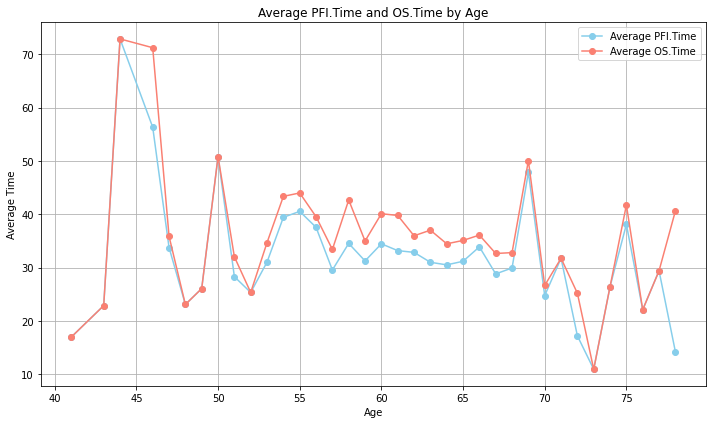

In [301]:
# Calculate average PFI.Time and OS.Time by age
avg_pfi = merged.groupby('Age')['PFI.time'].mean()
avg_os = merged.groupby('Age')['OS.time'].mean()

plt.figure(figsize=(10, 6))

plt.plot(avg_pfi.index, avg_pfi.values, marker='o', linestyle='-', color='skyblue', label='Average PFI.Time')

plt.plot(avg_os.index, avg_os.values, marker='o', linestyle='-', color='salmon', label='Average OS.Time')

plt.title('Average PFI.Time and OS.Time by Age')
plt.xlabel('Age')
plt.ylabel('Average Time')
plt.legend()

plt.grid(True)
plt.tight_layout()
plt.show()

In [302]:
average_age = merged['Age'].mean()
print(f"The average age is: {average_age:.2f}")

The average age is: 60.95


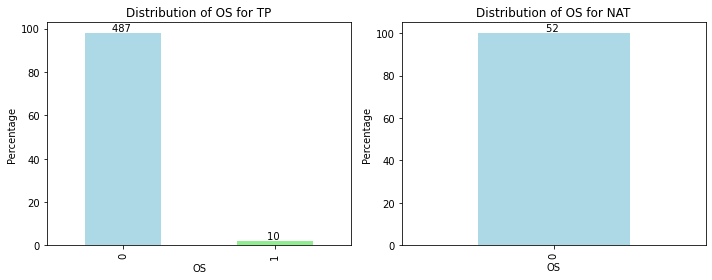

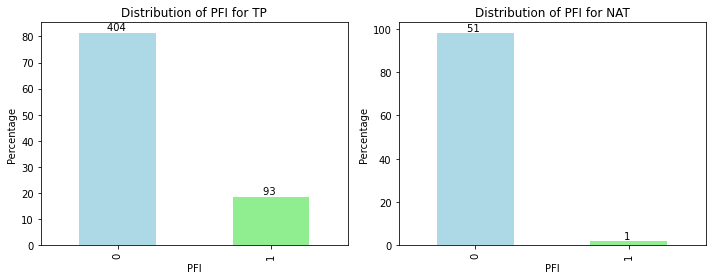

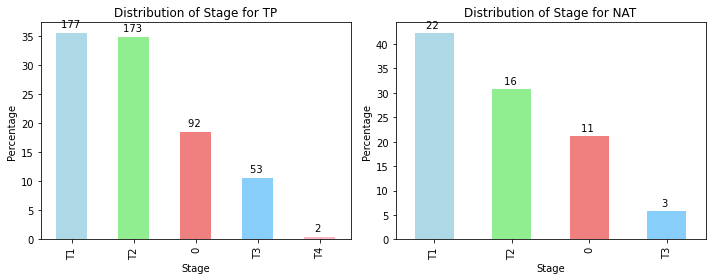

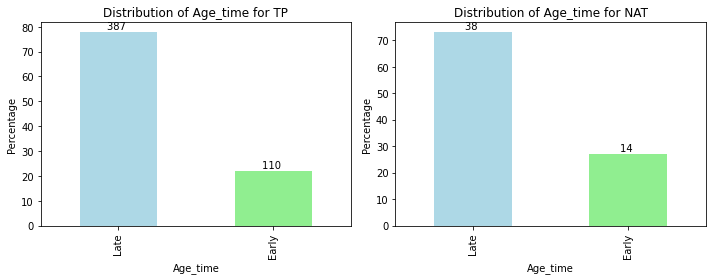

In [308]:
summary = {}

# Desired columns for analysis
columns_to_analyze = ['OS', 'PFI', 'Stage', 'Age_time']

# Column for division
column_to_divide = 'Tissue'

# Values for division
value1 = 'TP'
value2 = 'NAT'

for value in [value1, value2]:
    df_filtered = merged[merged[column_to_divide] == value]
    
    percentages = {}
    frequencies = {}
    
    for col in columns_to_analyze:
        counts = df_filtered[col].value_counts(normalize=False)  # Use normalize=False to get absolute counts
        percentages[col] = (counts / counts.sum() * 100).round(2)  # Calculate percentages
        frequencies[col] = counts
        
    summary[value] = {'percentages': percentages, 'frequencies': frequencies}
    
# Define colors for stages (adjust as needed)
colors_stage = ['lightblue', 'lightgreen', 'lightcoral', 'lightskyblue', 'lightpink']

# Plotting bar charts with absolute values
for col in columns_to_analyze:
    fig, axs = plt.subplots(1, 2, figsize=(10, 4))  # Create a subplot with 1 row and 2 columns
    
    for idx, (value, data) in enumerate(summary.items()):
        percentages_col = data['percentages'][col]
        frequencies_col = data['frequencies'][col]
        
        # Plot bar chart
        bars = percentages_col.plot(kind='bar', color=[colors_stage[i % len(colors_stage)] for i in range(len(percentages_col))], ax=axs[idx])
        
        # Add absolute values on top of each bar
        for index, values in enumerate(percentages_col):
            absolute_value = frequencies_col.iloc[index]  # Get the absolute value from frequencies
            axs[idx].text(index, values + 1, f"{absolute_value} ", ha='center')
        
        axs[idx].set_title(f'Distribution of {col} for {value}')
        axs[idx].set_xlabel(col)
        axs[idx].set_ylabel('Percentage')
    
    plt.tight_layout()
    plt.show()

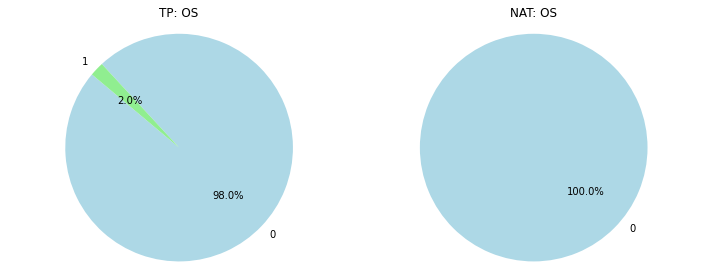

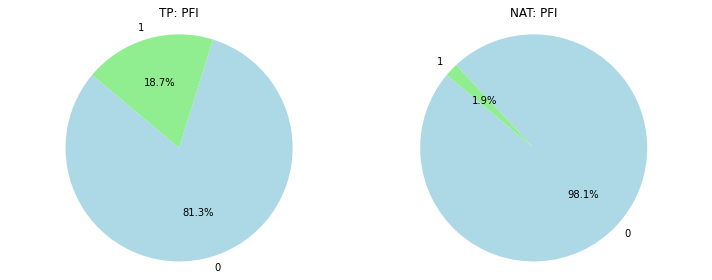

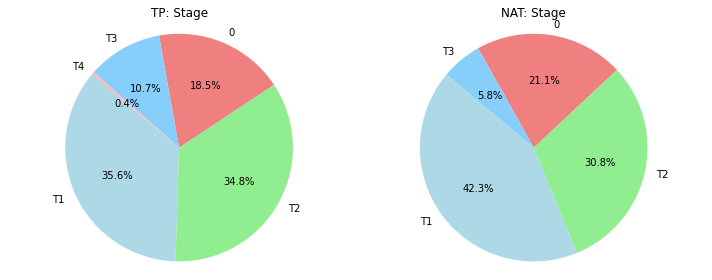

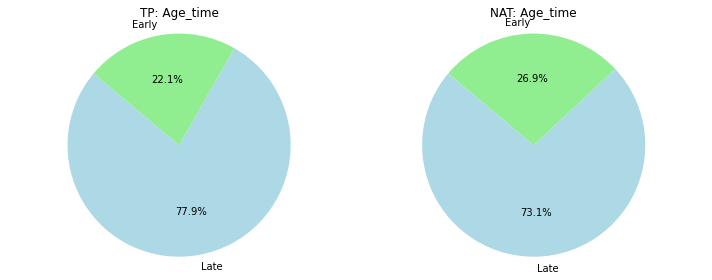

In [304]:
colors_stage = ['lightblue', 'lightgreen', 'lightcoral', 'lightskyblue', 'lightpink']

# Iterating over each column to create pie charts
for col in columns_to_analyze:
    fig, axs = plt.subplots(1, 2, figsize=(10, 4))  # Increases figure size for better display
    
    for idx, (value, data) in enumerate(summary.items()):
        percentages_col = data['percentages'][col]
        frequencies_col = data['frequencies'][col]
        
        # Plotting the pie chart
        axs[idx].pie(percentages_col, labels=percentages_col.index, colors=colors_stage, autopct='%1.1f%%', startangle=140)
        
        title = f'{value}: {col}\n'
       
        
        axs[idx].set_title(title.strip()) 
        
        axs[idx].axis('equal')
    
    plt.tight_layout()
    
    plt.show()

In [307]:
table_rows = []
for value, data in summary.items():
    row = [f"{value}"]

    for col, percentages_col in data['percentages'].items():
        frequencies_col = data['frequencies'][col]
        col_results = []
        for category, percentage in percentages_col.items():
            frequency = frequencies_col[category]
            col_results.append(f"{category}: {percentage:.2f}% ({frequency})")
            
        row.append("\n".join(col_results))
    table_rows.append(row)
    
headers = ["Columns"] + list(summary["TP"]["percentages"].keys())

table_str = tabulate(table_rows, headers=headers, tablefmt="grid")

title = "\033[1m Summary Table \033[0m"  
separator = '_' * len(table_str.split('\n')[0])  


print(f"\n{title}\n")
print(f"{separator}\n")
print(table_str)
print(f"\n{separator}\n")



 Summary Table 

__________________________________________________________________________________________

+-----------+-----------------+-----------------+------------------+---------------------+
| Columns   | OS              | PFI             | Stage            | Age_time            |
+===========+=================+=================+==================+=====================+
| TP        | 0: 97.99% (487) | 0: 81.29% (404) | T1: 35.61% (177) | Late: 77.87% (387)  |
|           | 1: 2.01% (10)   | 1: 18.71% (93)  | T2: 34.81% (173) | Early: 22.13% (110) |
|           |                 |                 | 0: 18.51% (92)   |                     |
|           |                 |                 | T3: 10.66% (53)  |                     |
|           |                 |                 | T4: 0.40% (2)    |                     |
+-----------+-----------------+-----------------+------------------+---------------------+
| NAT       | 0: 100.00% (52) | 0: 98.08% (51)  | T1: 42.31% (22)  | La

### Separation of the dataset based on tissue type

In [395]:
merged_TP = merged[merged['Tissue'] == 'TP']
merged_NAT = merged[merged['Tissue'] == 'NAT']

## TP

In [396]:
merged_TP

,sample,ID,Ctype,Tissue,Stage,OS,OS.time,PFI,PFI.time,Age,...,PLEKHG5,SELE,METTL11A,GNGT2,TULP3,PTRF,BCL6B,GSTK1,SELP,SELS
0,TCGA-2A-A8VL-01,TCGA-2A-A8VL,PRAD,TP,0,0,20.70,0,20.70,51.0,...,8.1084,9.2531,8.7355,2.4943,8.7872,13.0567,5.9843,10.5606,7.3276,11.2719
1,TCGA-2A-A8VO-01,TCGA-2A-A8VO,PRAD,TP,T1,0,56.70,0,56.70,57.0,...,6.9303,9.9090,8.3809,3.4554,8.9015,12.5682,7.1283,11.0117,8.1436,10.9057
2,TCGA-2A-A8VT-01,TCGA-2A-A8VT,PRAD,TP,T2,0,45.77,0,45.77,47.0,...,8.4985,6.3555,8.4089,2.9973,8.2230,11.0394,6.8451,10.3673,7.2489,10.5206
3,TCGA-2A-A8VV-01,TCGA-2A-A8VV,PRAD,TP,T2,0,22.37,0,22.37,52.0,...,7.1660,4.6440,8.5688,2.8316,8.8377,12.8527,5.5439,10.6838,7.6945,10.5403
4,TCGA-2A-A8VX-01,TCGA-2A-A8VX,PRAD,TP,T2,0,45.93,0,45.93,70.0,...,5.3683,7.1351,8.1491,2.0083,8.8054,11.9106,4.4368,9.9491,4.8435,11.0117
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
544,TCGA-ZG-A9M4-01,TCGA-ZG-A9M4,PRAD,TP,T2,0,18.23,0,18.23,65.0,...,7.2214,8.4980,8.6913,4.3071,8.9407,11.9891,6.7635,10.8776,8.4687,9.5981
545,TCGA-ZG-A9MC-01,TCGA-ZG-A9MC,PRAD,TP,T2,0,15.17,0,15.17,69.0,...,8.5367,9.3211,8.8162,5.3413,9.3222,12.9678,7.7122,11.1051,8.7036,9.8359
546,TCGA-ZG-A9N3-01,TCGA-ZG-A9N3,PRAD,TP,T1,0,11.63,0,11.63,73.0,...,6.4813,9.0886,9.5033,3.2045,9.1809,12.3132,6.2672,10.0204,7.5305,9.8283
547,TCGA-ZG-A9ND-01,TCGA-ZG-A9ND,PRAD,TP,T1,0,13.67,0,13.67,55.0,...,5.5860,8.6417,9.1619,2.9849,8.5700,11.2957,7.1367,10.7352,6.7941,11.2749


Criating a new dataset for shapiro and wilcoxon testing.

In [398]:
df_PFI = merged_TP[['ID', 'PFI']].copy()

colunas_a_excluir = ['sample','Ctype', 'Tissue', 'Stage', 'OS', 'OS.time', 'PFI',
       'PFI.time', 'Age', 'Age_time']

colunas_a_manter = merged_TP.columns.difference(colunas_a_excluir)

df_gene = merged_TP[colunas_a_manter].copy()

merged_df = pd.merge(df_PFI, df_gene, on='ID', how='outer')

df_PFI_0 = merged_df[merged_df['PFI'] == 0]
df_PFI_1 = merged_df[merged_df['PFI'] == 1]

sorted_merged_df = pd.concat([df_PFI_0, df_PFI_1])

sorted_merged_df

,ID,PFI,A1BG,A2LD1,A2M,A2ML1,A4GALT,AAAS,AACS,AADAT,...,ZWINT,ZXDA,ZXDB,ZXDC,ZYG11A,ZYG11B,ZYX,ZZEF1,ZZZ3,psiTPTE22
0,TCGA-2A-A8VL,0,6.1068,7.0985,12.2375,5.5334,9.5864,9.8514,9.9425,9.5363,...,6.6194,5.6114,8.1560,10.1065,5.2893,9.4369,11.1704,10.5408,8.9834,7.6459
1,TCGA-2A-A8VO,0,4.2437,7.4108,14.2878,1.8713,8.9795,9.8489,10.0026,8.7359,...,7.8924,5.4219,8.5868,9.8279,7.3965,9.5648,11.4058,9.7398,9.3257,8.1936
2,TCGA-2A-A8VT,0,4.1781,7.3220,12.2608,1.0724,7.9779,9.6483,10.0788,7.8504,...,6.9346,6.8359,9.2286,10.7554,5.5073,10.2189,10.5845,11.0239,10.4247,5.2106
3,TCGA-2A-A8VV,0,4.2181,7.4619,13.0411,0.9570,8.8627,9.7809,10.0121,9.3286,...,7.2033,5.5145,8.7219,9.9903,6.0329,9.2616,11.5794,10.0095,10.0363,4.4711
4,TCGA-2A-A8VX,0,5.4763,8.0450,13.0244,1.8152,8.8439,9.9919,9.8682,9.4519,...,8.2895,4.6545,8.4908,9.9594,7.3641,9.4705,11.1503,9.7115,9.5579,3.8683
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
471,TCGA-YL-A9WX,1,5.6455,6.3560,13.5661,4.8002,9.4220,9.7124,9.8661,8.1874,...,6.7452,6.4059,9.0436,10.3671,5.1117,9.7329,11.3981,10.7153,9.6282,8.1538
472,TCGA-YL-A9WY,1,6.0336,7.1375,14.6851,4.5808,8.9479,9.7355,9.7622,8.6787,...,8.0778,5.8702,8.5101,10.2088,8.2035,10.0433,12.3472,9.9562,9.6122,6.1250
480,TCGA-ZG-A9L2,1,5.3566,6.4630,15.7569,2.6436,9.0714,9.5867,10.5055,9.0308,...,8.6964,5.8562,8.4835,10.1538,6.9745,9.8244,12.4010,10.0267,9.4626,6.5710
483,TCGA-ZG-A9L6,1,6.1016,6.7782,15.1270,3.8263,9.2008,9.3594,9.6384,8.4579,...,7.4975,5.7214,8.5622,9.9932,4.5820,10.1845,11.8087,9.9918,9.5724,5.9999


## Shapiro Test

Performing the shapiro test to understand the normality of each value in our dataset

In [399]:
shapiro_results = []

p_less_005 = 0
p_more_005 = 0

for column in sorted_merged_df.columns:
    if pd.api.types.is_numeric_dtype(sorted_merged_df[column]):
        stat, p_value = shapiro(sorted_merged_df[column])
        shapiro_results.append({'Column': column, 'Statistic': stat, 'P-value': p_value})
        if p_value < 0.05:
            p_less_005 += 1
        else:
            p_more_005 += 1
    
shapiro_df = pd.DataFrame(shapiro_results)

print(f"Nº p < 0.05: {p_less_005}")
print(f"Nº p >= 0.05: {p_more_005}")

shapiro_df

Nº p < 0.05: 12079
Nº p >= 0.05: 2854


,Column,Statistic,P-value
0,PFI,0.474934,1.002705e-35
1,A1BG,0.992215,1.070587e-02
2,A2LD1,0.983987,2.744841e-05
3,A2M,0.996785,4.303018e-01
4,A2ML1,0.992088,9.652994e-03
...,...,...,...
14928,ZYG11B,0.985892,9.597551e-05
14929,ZYX,0.998372,9.279507e-01
14930,ZZEF1,0.990807,3.467165e-03
14931,ZZZ3,0.979124,1.498229e-06


We conclude, as most of our values have a p-value < 0.05, our data does not have a normal distribution, so we must do wilcoxon testing.

## Wilcoxon Test

In [400]:
wilcoxon_results = {}

for column in sorted_merged_df.columns[2:]:
    # Select an equal number of IDs from each group
    min_length = min(len(df_PFI_0), len(df_PFI_1))
    df_PFI_0_sampled = df_PFI_0.sample(min_length, random_state=42)
    df_PFI_1_sampled = df_PFI_1.sample(min_length, random_state=42)
    
    # Perform the Wilcoxon test for the current column
    wilcoxon_stat, p_value = wilcoxon(df_PFI_0_sampled[column], df_PFI_1_sampled[column])
    
    # Store test results in a dictionary
    wilcoxon_results[column] = {'Wilcoxon Stat': wilcoxon_stat, 'P-value': p_value}

wilcoxon_df = pd.DataFrame.from_dict(wilcoxon_results, orient='index')

In [401]:
wilcoxon_df

,Wilcoxon Stat,P-value
A1BG,1715.0,0.071425
A2LD1,1642.0,0.037299
A2M,2006.0,0.491597
A2ML1,1854.0,0.204023
A4GALT,1897.0,0.268980
...,...,...
ZYG11B,1957.0,0.381292
ZYX,1848.0,0.195955
ZZEF1,2014.0,0.511105
ZZZ3,2112.0,0.778233


Separate the genes based on their p-value.

In [402]:
p_value_less005 = 0
p_value_higher005 = 0

for p_value in wilcoxon_df['P-value']:
    if p_value < 0.05:
        p_value_less005 += 1
    else:
        p_value_higher005 += 1

print("Genes with p-value < 0.05:", p_value_less005)
print("Genes with p-value >= 0.05:", p_value_higher005)

Genes with p-value < 0.05: 2686
Genes with p-value >= 0.05: 12246


Finally, we filter our initial dataset, only keeping the genes with p-value < 0.05, creating a new updated with only those genes.

In [403]:
wilcoxon_filtered = wilcoxon_df[wilcoxon_df['P-value'] < 0.05]

In [404]:
wilcoxon_filtered

,Wilcoxon Stat,P-value
A2LD1,1642.0,0.037299
ABAT,1445.0,0.004550
ABCA2,1464.5,0.005735
ABCB9,1406.0,0.002820
ABCC5,1327.5,0.001011
...,...,...
ZNRF3,1653.0,0.041318
ZRANB3,1644.5,0.038182
ZRSR2,1480.0,0.006868
ZSWIM4,1275.0,0.000485


Visualize de merged dataset columns and their respective data types.

In [405]:
merged_TP_filtered = merged_TP.drop(columns=wilcoxon_df[wilcoxon_df['P-value'] >= 0.05].index)

In [406]:
merged_TP_filtered

,sample,ID,Ctype,Tissue,Stage,OS,OS.time,PFI,PFI.time,Age,...,FAM8A1,FAM5C,C11orf73,IL4I1,NFIA,TCEAL4,BTN2A1,BRPF1,TTLL13,ACAP3
0,TCGA-2A-A8VL-01,TCGA-2A-A8VL,PRAD,TP,0,0,20.70,0,20.70,51.0,...,10.2604,7.5500,8.1164,4.8741,10.5621,11.9600,8.8657,8.7703,3.1113,9.2560
1,TCGA-2A-A8VO-01,TCGA-2A-A8VO,PRAD,TP,T1,0,56.70,0,56.70,57.0,...,10.0441,7.9401,8.4994,6.1681,10.7957,12.0192,8.8504,8.4536,4.2156,9.5788
2,TCGA-2A-A8VT-01,TCGA-2A-A8VT,PRAD,TP,T2,0,45.77,0,45.77,47.0,...,9.9132,6.3425,7.9884,5.5927,9.7577,11.1932,8.5714,9.4434,4.0233,9.7450
3,TCGA-2A-A8VV-01,TCGA-2A-A8VV,PRAD,TP,T2,0,22.37,0,22.37,52.0,...,9.7520,6.3895,8.8243,4.3538,10.4650,11.9437,8.7474,8.7740,2.7702,9.1420
4,TCGA-2A-A8VX-01,TCGA-2A-A8VX,PRAD,TP,T2,0,45.93,0,45.93,70.0,...,11.0011,2.8168,8.8752,5.2067,10.8698,12.1138,8.5809,8.6834,4.2959,9.6766
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
544,TCGA-ZG-A9M4-01,TCGA-ZG-A9M4,PRAD,TP,T2,0,18.23,0,18.23,65.0,...,10.0037,10.5751,9.0907,6.4591,9.8672,11.6759,8.9569,8.8273,3.6053,9.9996
545,TCGA-ZG-A9MC-01,TCGA-ZG-A9MC,PRAD,TP,T2,0,15.17,0,15.17,69.0,...,9.8733,8.9773,8.5599,8.3718,10.6507,11.3485,9.3634,9.2315,3.0492,8.9297
546,TCGA-ZG-A9N3-01,TCGA-ZG-A9N3,PRAD,TP,T1,0,11.63,0,11.63,73.0,...,10.4106,3.0340,9.8796,6.0519,9.9427,11.4128,9.1342,8.5740,4.9425,9.2413
547,TCGA-ZG-A9ND-01,TCGA-ZG-A9ND,PRAD,TP,T1,0,13.67,0,13.67,55.0,...,9.9932,6.0296,8.9100,4.4846,10.9915,11.5117,8.2477,8.8615,4.0505,8.7845


In [407]:
for column in merged_TP_filtered.columns:
    print(f"Column: {column} - Data type: {merged_TP_filtered[column].dtype}")

Column: sample - Data type: object
Column: ID - Data type: object
Column: Ctype - Data type: object
Column: Tissue - Data type: object
Column: Stage - Data type: object
Column: OS - Data type: int64
Column: OS.time - Data type: float64
Column: PFI - Data type: int64
Column: PFI.time - Data type: float64
Column: Age - Data type: float64
Column: Age_time - Data type: object
Column: RNF13 - Data type: float64
Column: NCBP2 - Data type: float64
Column: ZNF700 - Data type: float64
Column: ZNF707 - Data type: float64
Column: TCOF1 - Data type: float64
Column: SPPL3 - Data type: float64
Column: ZNF646 - Data type: float64
Column: GTSE1 - Data type: float64
Column: ARFRP1 - Data type: float64
Column: ITGA2 - Data type: float64
Column: DENND4B - Data type: float64
Column: LOC100132287 - Data type: float64
Column: FBXL12 - Data type: float64
Column: GHDC - Data type: float64
Column: KIAA0895L - Data type: float64
Column: CHST1 - Data type: float64
Column: ITGAX - Data type: float64
Column: MUS81

Column: SF3B2 - Data type: float64
Column: SEMA6C - Data type: float64
Column: CNIH2 - Data type: float64
Column: ADCK5 - Data type: float64
Column: DNAJC10 - Data type: float64
Column: MS4A6A - Data type: float64
Column: LMAN1 - Data type: float64
Column: EPR1 - Data type: float64
Column: LOC642846 - Data type: float64
Column: YWHAQ - Data type: float64
Column: PPM1L - Data type: float64
Column: ZNF17 - Data type: float64
Column: CWC25 - Data type: float64
Column: TMED10 - Data type: float64
Column: PRPF31 - Data type: float64
Column: FMOD - Data type: float64
Column: FMO3 - Data type: float64
Column: ZNF202 - Data type: float64
Column: FMO4 - Data type: float64
Column: FMO5 - Data type: float64
Column: FNDC3A - Data type: float64
Column: KIAA1797 - Data type: float64
Column: SETD4 - Data type: float64
Column: SETD7 - Data type: float64
Column: PSRC1 - Data type: float64
Column: PRSS27 - Data type: float64
Column: SURF6 - Data type: float64
Column: EME1 - Data type: float64
Column: EM

We sampled 100 out of the 404 IDs with PFI=0, so our tests could obtain more conclusive and respectable results.

In [408]:
PFI_0 = merged_TP_filtered[merged_TP_filtered['PFI'] == 0]
PFI_1 = merged_TP_filtered[merged_TP_filtered['PFI'] == 1]

# Sampling of 100 IDs with PFI = 0
sampled_PFI_0 = PFI_0.sample(n=100, random_state=42)

# Combine the datasets with PFI = 0 and PFI = 1
merged_sampled = pd.concat([sampled_PFI_0, PFI_1])

In [409]:
merged_sampled

,sample,ID,Ctype,Tissue,Stage,OS,OS.time,PFI,PFI.time,Age,...,FAM8A1,FAM5C,C11orf73,IL4I1,NFIA,TCEAL4,BTN2A1,BRPF1,TTLL13,ACAP3
83,TCGA-EJ-7123-01,TCGA-EJ-7123,PRAD,TP,T1,0,85.73,0,85.73,59.0,...,10.4612,9.5169,7.7423,5.4008,10.6711,11.0854,7.7502,8.7665,3.0529,8.6078
295,TCGA-HC-A6AO-01,TCGA-HC-A6AO,PRAD,TP,T1,0,17.67,0,17.67,52.0,...,9.2820,4.7504,9.4829,8.2514,9.8304,11.2776,8.4794,8.2682,3.5126,9.7606
526,TCGA-ZG-A8QX-01,TCGA-ZG-A8QX,PRAD,TP,T1,0,14.73,0,14.73,56.0,...,10.0831,7.9295,8.7492,5.3564,10.6778,12.0042,8.5052,8.5643,3.1828,9.1969
40,TCGA-CH-5772-01,TCGA-CH-5772,PRAD,TP,0,0,16.20,0,16.20,63.0,...,10.3882,9.1392,8.3931,4.1803,10.9699,11.6951,8.6187,8.9329,3.2820,7.9243
50,TCGA-EJ-5497-01,TCGA-EJ-5497,PRAD,TP,T2,0,13.50,0,13.50,47.0,...,10.6966,6.8085,7.8534,4.5995,11.1247,11.2143,8.2622,8.2154,2.9731,7.8022
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
523,TCGA-YL-A9WX-01,TCGA-YL-A9WX,PRAD,TP,T3,0,50.60,1,50.20,68.0,...,10.2457,7.2612,8.2202,5.8424,10.5555,11.4071,9.2521,9.2555,3.8725,9.2776
524,TCGA-YL-A9WY-01,TCGA-YL-A9WY,PRAD,TP,T3,0,36.60,1,25.50,57.0,...,10.1639,5.0256,8.7595,7.1185,10.1627,11.9782,9.2772,8.8966,3.7192,9.8364
532,TCGA-ZG-A9L2-01,TCGA-ZG-A9L2,PRAD,TP,T3,0,38.47,1,6.00,70.0,...,10.2168,5.9814,8.8046,6.6914,10.9103,12.5305,9.3277,8.5992,2.4652,9.4081
535,TCGA-ZG-A9L6-01,TCGA-ZG-A9L6,PRAD,TP,T1,0,22.90,1,22.13,64.0,...,10.5405,7.6243,8.4639,4.8795,10.9848,12.1050,9.3334,9.1321,4.0115,9.0916


In [410]:
merged_sampled.isnull().sum()

sample    0
ID        0
Ctype     0
Tissue    0
Stage     0
         ..
TCEAL4    0
BTN2A1    0
BRPF1     0
TTLL13    0
ACAP3     0
Length: 2697, dtype: int64

Creating a new dataset with only numeric columns for testing porposes.
We also removed some patological columns that were not, in our opinion, necessary for this study.

In [114]:
# Identify numeric columns
numeric_columns = merged_sampled.select_dtypes(include=['float64', 'int64']).columns

numeric = merged_sampled[numeric_columns]

# List of columns to be removed
colunas_patologicas = ['OS.time','OS','PFI.time', 'Age']

numeric_gene = numeric.drop(columns=colunas_patologicas)
print(numeric_gene.columns)

Index(['PFI', 'RNF13', 'NCBP2', 'ZNF700', 'ZNF707', 'TCOF1', 'SPPL3', 'ZNF646',
       'GTSE1', 'ARFRP1',
       ...
       'FAM8A1', 'FAM5C', 'C11orf73', 'IL4I1', 'NFIA', 'TCEAL4', 'BTN2A1',
       'BRPF1', 'TTLL13', 'ACAP3'],
      dtype='object', length=2687)


In [115]:
numeric_gene

,PFI,RNF13,NCBP2,ZNF700,ZNF707,TCOF1,SPPL3,ZNF646,GTSE1,ARFRP1,...,FAM8A1,FAM5C,C11orf73,IL4I1,NFIA,TCEAL4,BTN2A1,BRPF1,TTLL13,ACAP3
83,0,10.9750,10.5501,7.6244,7.8215,10.0322,10.3995,8.9565,5.6755,9.0597,...,10.4612,9.5169,7.7423,5.4008,10.6711,11.0854,7.7502,8.7665,3.0529,8.6078
295,0,10.3153,11.1007,7.3403,9.3012,10.3247,10.3546,8.1509,5.7107,10.6662,...,9.2820,4.7504,9.4829,8.2514,9.8304,11.2776,8.4794,8.2682,3.5126,9.7606
526,0,9.8083,10.5997,7.7676,7.4928,9.8487,10.2096,8.3897,5.2312,9.9624,...,10.0831,7.9295,8.7492,5.3564,10.6778,12.0042,8.5052,8.5643,3.1828,9.1969
40,0,11.2294,11.0709,7.7497,6.7405,9.8185,10.5167,8.5474,4.5320,8.7727,...,10.3882,9.1392,8.3931,4.1803,10.9699,11.6951,8.6187,8.9329,3.2820,7.9243
50,0,11.0698,10.2591,8.2216,7.0546,9.5353,10.2471,8.8714,4.1374,8.7092,...,10.6966,6.8085,7.8534,4.5995,11.1247,11.2143,8.2622,8.2154,2.9731,7.8022
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
523,1,10.6262,10.5788,8.5281,7.9627,9.9827,10.3442,9.3739,4.6902,9.5601,...,10.2457,7.2612,8.2202,5.8424,10.5555,11.4071,9.2521,9.2555,3.8725,9.2776
524,1,10.5310,11.1520,8.3780,8.0654,10.2456,10.2648,9.0383,6.9844,9.8880,...,10.1639,5.0256,8.7595,7.1185,10.1627,11.9782,9.2772,8.8966,3.7192,9.8364
532,1,10.3338,10.2977,7.6529,7.3902,10.1548,10.1337,8.7942,6.7385,9.9213,...,10.2168,5.9814,8.8046,6.6914,10.9103,12.5305,9.3277,8.5992,2.4652,9.4081
535,1,10.7567,10.7120,7.9115,7.6243,10.0567,10.1662,8.9939,4.4593,9.8811,...,10.5405,7.6243,8.4639,4.8795,10.9848,12.1050,9.3334,9.1321,4.0115,9.0916


In [285]:
numeric_gene.isnull().sum()

PFI       0
RNF13     0
NCBP2     0
ZNF700    0
ZNF707    0
         ..
TCEAL4    0
BTN2A1    0
BRPF1     0
TTLL13    0
ACAP3     0
Length: 2687, dtype: int64

### Tests

In [246]:
#Choose my target feature
column_chosen = 'PFI'

# Separation between my X (set of features) and y (target feature)
X = numeric_gene.drop(columns=[column_chosen])  # X is all features except the target feature
y = numeric_gene[column_chosen]  # y is the target feature

In [247]:
print("Feature Set (X):")
print(X.head())
print("\nTarget feature (y):")
print(y.head())

Feature Set (X):
       RNF13    NCBP2  ZNF700  ZNF707    TCOF1    SPPL3  ZNF646   GTSE1  \
83   10.9750  10.5501  7.6244  7.8215  10.0322  10.3995  8.9565  5.6755   
295  10.3153  11.1007  7.3403  9.3012  10.3247  10.3546  8.1509  5.7107   
526   9.8083  10.5997  7.7676  7.4928   9.8487  10.2096  8.3897  5.2312   
40   11.2294  11.0709  7.7497  6.7405   9.8185  10.5167  8.5474  4.5320   
50   11.0698  10.2591  8.2216  7.0546   9.5353  10.2471  8.8714  4.1374   

      ARFRP1    ITGA2  ...   FAM8A1   FAM5C  C11orf73   IL4I1     NFIA  \
83    9.0597   8.8088  ...  10.4612  9.5169    7.7423  5.4008  10.6711   
295  10.6662   6.4054  ...   9.2820  4.7504    9.4829  8.2514   9.8304   
526   9.9624   7.2842  ...  10.0831  7.9295    8.7492  5.3564  10.6778   
40    8.7727   8.5805  ...  10.3882  9.1392    8.3931  4.1803  10.9699   
50    8.7092  10.2526  ...  10.6966  6.8085    7.8534  4.5995  11.1247   

      TCEAL4  BTN2A1   BRPF1  TTLL13   ACAP3  
83   11.0854  7.7502  8.7665  3.0529  8.

In [248]:
# Definition of the models and their parameter grids
models = {
    'Logistic Regression': {
        'model': LogisticRegression(),
        'param_grid': {'C': [0.1, 1, 10], 
                       'solver': ['liblinear', 'saga'], 
                       'penalty': ['l1', 'l2']}
    },
    'Decision Tree': {
        'model': DecisionTreeClassifier(),
        'param_grid': {'max_depth': [None, 5, 10], 
                       'criterion': ['gini', 'entropy']}
    },
    'Random Forest': {
        'model': RandomForestClassifier(),
        'param_grid': {'n_estimators': [50, 100, 200], 
                       'max_depth': [None, 10, 20], 
                       'criterion': ['gini', 'entropy']}
    },
    'Gradient Boosting': {
        'model': GradientBoostingClassifier(),
        'param_grid': {'n_estimators': [50, 100, 200], 
                       'learning_rate': [0.01, 0.1, 0.5],
                       'max_depth': [3, 5, 10],
                       'criterion': ['friedman_mse', 'squared_error']}
    }
}

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42,stratify=y)

# Standardize the data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

best_params_all = {}
best_scores_all = {}
metrics_all = {}
roc_curves = {}
conf_matrices = {}
importances = {}

In [249]:
# Perform grid search for each model
for model_name, model_data in models.items():
    print(f"Running GridSearchCV for {model_name}...")
    
    try:
        grid_search = GridSearchCV(model_data['model'], model_data['param_grid'], cv=5, n_jobs=1, verbose=2)
        grid_search.fit(X_train_scaled, y_train)
        
        # Get the best hyperparameters
        best_params = grid_search.best_params_
        
        # Get the best score
        best_score = grid_search.best_score_
     
        # Store the best hyperparameters and best score for the current model
        best_params_all[model_name] = best_params
        best_scores_all[model_name] = best_score

        best_model = grid_search.best_estimator_
        best_model.fit(X_train_scaled, y_train)
        
        y_pred = best_model.predict(X_test_scaled)
        y_proba = best_model.predict_proba(X_test_scaled)[:, 1]

        roc_auc = roc_auc_score(y_test, y_proba)
        precision = precision_score(y_test, y_pred)
        recall = recall_score(y_test, y_pred)
        f1 = f1_score(y_test, y_pred)

        metrics_all[model_name] = {
            'Best Accuracy (GridSearchCV)': best_score,
            'ROC AUC': roc_auc,
            'Precision': precision,
            'Recall': recall,
            'F1 Score': f1
        }

        fpr, tpr, _ = roc_curve(y_test, y_proba)
        roc_curves[model_name] = (fpr, tpr, roc_auc)
        
        conf_matrix = confusion_matrix(y_test, y_pred)
        conf_matrices[model_name] = conf_matrix
        
        if model_name == 'Logistic Regression':
            importance_scores = np.abs(best_model.coef_[0])
        else:
            importance_scores = best_model.feature_importances_
        
        importances[model_name] = importance_scores

    except Exception as e:
        print(f"Error occurred for {model_name}: {e}")

Running GridSearchCV for Logistic Regression...
Fitting 5 folds for each of 12 candidates, totalling 60 fits
[CV] END ................C=0.1, penalty=l1, solver=liblinear; total time=   0.0s
[CV] END ................C=0.1, penalty=l1, solver=liblinear; total time=   0.0s
[CV] END ................C=0.1, penalty=l1, solver=liblinear; total time=   0.0s
[CV] END ................C=0.1, penalty=l1, solver=liblinear; total time=   0.0s
[CV] END ................C=0.1, penalty=l1, solver=liblinear; total time=   0.0s


C:\Users\andre\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END .....................C=0.1, penalty=l1, solver=saga; total time=   1.3s


C:\Users\andre\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END .....................C=0.1, penalty=l1, solver=saga; total time=   1.3s


C:\Users\andre\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END .....................C=0.1, penalty=l1, solver=saga; total time=   1.3s


C:\Users\andre\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END .....................C=0.1, penalty=l1, solver=saga; total time=   1.2s


C:\Users\andre\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END .....................C=0.1, penalty=l1, solver=saga; total time=   1.2s
[CV] END ................C=0.1, penalty=l2, solver=liblinear; total time=   0.1s
[CV] END ................C=0.1, penalty=l2, solver=liblinear; total time=   0.1s
[CV] END ................C=0.1, penalty=l2, solver=liblinear; total time=   0.1s
[CV] END ................C=0.1, penalty=l2, solver=liblinear; total time=   0.1s
[CV] END ................C=0.1, penalty=l2, solver=liblinear; total time=   0.1s


C:\Users\andre\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END .....................C=0.1, penalty=l2, solver=saga; total time=   1.1s


C:\Users\andre\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END .....................C=0.1, penalty=l2, solver=saga; total time=   1.3s


C:\Users\andre\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END .....................C=0.1, penalty=l2, solver=saga; total time=   1.1s


C:\Users\andre\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END .....................C=0.1, penalty=l2, solver=saga; total time=   1.1s


C:\Users\andre\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END .....................C=0.1, penalty=l2, solver=saga; total time=   1.1s
[CV] END ..................C=1, penalty=l1, solver=liblinear; total time=   0.0s
[CV] END ..................C=1, penalty=l1, solver=liblinear; total time=   0.0s
[CV] END ..................C=1, penalty=l1, solver=liblinear; total time=   0.0s
[CV] END ..................C=1, penalty=l1, solver=liblinear; total time=   0.0s
[CV] END ..................C=1, penalty=l1, solver=liblinear; total time=   0.0s


C:\Users\andre\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END .......................C=1, penalty=l1, solver=saga; total time=   1.7s


C:\Users\andre\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END .......................C=1, penalty=l1, solver=saga; total time=   1.8s


C:\Users\andre\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END .......................C=1, penalty=l1, solver=saga; total time=   1.9s


C:\Users\andre\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END .......................C=1, penalty=l1, solver=saga; total time=   1.7s


C:\Users\andre\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END .......................C=1, penalty=l1, solver=saga; total time=   1.8s
[CV] END ..................C=1, penalty=l2, solver=liblinear; total time=   0.2s
[CV] END ..................C=1, penalty=l2, solver=liblinear; total time=   0.2s
[CV] END ..................C=1, penalty=l2, solver=liblinear; total time=   0.2s
[CV] END ..................C=1, penalty=l2, solver=liblinear; total time=   0.2s
[CV] END ..................C=1, penalty=l2, solver=liblinear; total time=   0.1s


C:\Users\andre\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END .......................C=1, penalty=l2, solver=saga; total time=   1.3s


C:\Users\andre\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END .......................C=1, penalty=l2, solver=saga; total time=   1.3s


C:\Users\andre\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END .......................C=1, penalty=l2, solver=saga; total time=   1.3s


C:\Users\andre\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END .......................C=1, penalty=l2, solver=saga; total time=   1.1s


C:\Users\andre\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END .......................C=1, penalty=l2, solver=saga; total time=   1.2s
[CV] END .................C=10, penalty=l1, solver=liblinear; total time=   0.0s
[CV] END .................C=10, penalty=l1, solver=liblinear; total time=   0.0s
[CV] END .................C=10, penalty=l1, solver=liblinear; total time=   0.0s
[CV] END .................C=10, penalty=l1, solver=liblinear; total time=   0.0s
[CV] END .................C=10, penalty=l1, solver=liblinear; total time=   0.0s


C:\Users\andre\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END ......................C=10, penalty=l1, solver=saga; total time=   1.9s


C:\Users\andre\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END ......................C=10, penalty=l1, solver=saga; total time=   1.9s


C:\Users\andre\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END ......................C=10, penalty=l1, solver=saga; total time=   1.8s


C:\Users\andre\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END ......................C=10, penalty=l1, solver=saga; total time=   1.7s


C:\Users\andre\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END ......................C=10, penalty=l1, solver=saga; total time=   1.6s
[CV] END .................C=10, penalty=l2, solver=liblinear; total time=   0.2s
[CV] END .................C=10, penalty=l2, solver=liblinear; total time=   0.1s
[CV] END .................C=10, penalty=l2, solver=liblinear; total time=   0.1s
[CV] END .................C=10, penalty=l2, solver=liblinear; total time=   0.1s
[CV] END .................C=10, penalty=l2, solver=liblinear; total time=   0.2s


C:\Users\andre\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END ......................C=10, penalty=l2, solver=saga; total time=   0.9s


C:\Users\andre\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END ......................C=10, penalty=l2, solver=saga; total time=   0.9s


C:\Users\andre\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END ......................C=10, penalty=l2, solver=saga; total time=   1.1s


C:\Users\andre\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END ......................C=10, penalty=l2, solver=saga; total time=   1.0s


C:\Users\andre\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END ......................C=10, penalty=l2, solver=saga; total time=   1.0s


C:\Users\andre\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\andre\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


Running GridSearchCV for Decision Tree...
Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV] END .....................criterion=gini, max_depth=None; total time=   0.8s
[CV] END .....................criterion=gini, max_depth=None; total time=   0.9s
[CV] END .....................criterion=gini, max_depth=None; total time=   0.9s
[CV] END .....................criterion=gini, max_depth=None; total time=   1.0s
[CV] END .....................criterion=gini, max_depth=None; total time=   0.7s
[CV] END ........................criterion=gini, max_depth=5; total time=   0.8s
[CV] END ........................criterion=gini, max_depth=5; total time=   0.8s
[CV] END ........................criterion=gini, max_depth=5; total time=   0.8s
[CV] END ........................criterion=gini, max_depth=5; total time=   0.7s
[CV] END ........................criterion=gini, max_depth=5; total time=   0.7s
[CV] END .......................criterion=gini, max_depth=10; total time=   0.7s
[CV] EN

[CV] END ..criterion=entropy, max_depth=10, n_estimators=100; total time=   1.9s
[CV] END ..criterion=entropy, max_depth=10, n_estimators=200; total time=   3.9s
[CV] END ..criterion=entropy, max_depth=10, n_estimators=200; total time=   3.9s
[CV] END ..criterion=entropy, max_depth=10, n_estimators=200; total time=   3.8s
[CV] END ..criterion=entropy, max_depth=10, n_estimators=200; total time=   3.9s
[CV] END ..criterion=entropy, max_depth=10, n_estimators=200; total time=   3.9s
[CV] END ...criterion=entropy, max_depth=20, n_estimators=50; total time=   0.9s
[CV] END ...criterion=entropy, max_depth=20, n_estimators=50; total time=   0.9s
[CV] END ...criterion=entropy, max_depth=20, n_estimators=50; total time=   0.9s
[CV] END ...criterion=entropy, max_depth=20, n_estimators=50; total time=   0.9s
[CV] END ...criterion=entropy, max_depth=20, n_estimators=50; total time=   0.9s
[CV] END ..criterion=entropy, max_depth=20, n_estimators=100; total time=   2.0s
[CV] END ..criterion=entropy

[CV] END criterion=friedman_mse, learning_rate=0.1, max_depth=5, n_estimators=50; total time=  16.8s
[CV] END criterion=friedman_mse, learning_rate=0.1, max_depth=5, n_estimators=50; total time=  12.6s
[CV] END criterion=friedman_mse, learning_rate=0.1, max_depth=5, n_estimators=100; total time=  27.5s
[CV] END criterion=friedman_mse, learning_rate=0.1, max_depth=5, n_estimators=100; total time=  32.4s
[CV] END criterion=friedman_mse, learning_rate=0.1, max_depth=5, n_estimators=100; total time=  28.7s
[CV] END criterion=friedman_mse, learning_rate=0.1, max_depth=5, n_estimators=100; total time=  33.5s
[CV] END criterion=friedman_mse, learning_rate=0.1, max_depth=5, n_estimators=100; total time=  25.5s
[CV] END criterion=friedman_mse, learning_rate=0.1, max_depth=5, n_estimators=200; total time=  48.8s
[CV] END criterion=friedman_mse, learning_rate=0.1, max_depth=5, n_estimators=200; total time=  53.6s
[CV] END criterion=friedman_mse, learning_rate=0.1, max_depth=5, n_estimators=200; t

[CV] END criterion=squared_error, learning_rate=0.01, max_depth=3, n_estimators=100; total time=  22.3s
[CV] END criterion=squared_error, learning_rate=0.01, max_depth=3, n_estimators=200; total time=  44.5s
[CV] END criterion=squared_error, learning_rate=0.01, max_depth=3, n_estimators=200; total time=  44.4s
[CV] END criterion=squared_error, learning_rate=0.01, max_depth=3, n_estimators=200; total time=  44.6s
[CV] END criterion=squared_error, learning_rate=0.01, max_depth=3, n_estimators=200; total time=  44.3s
[CV] END criterion=squared_error, learning_rate=0.01, max_depth=3, n_estimators=200; total time=  44.3s
[CV] END criterion=squared_error, learning_rate=0.01, max_depth=5, n_estimators=50; total time=  14.0s
[CV] END criterion=squared_error, learning_rate=0.01, max_depth=5, n_estimators=50; total time=  14.7s
[CV] END criterion=squared_error, learning_rate=0.01, max_depth=5, n_estimators=50; total time=  15.2s
[CV] END criterion=squared_error, learning_rate=0.01, max_depth=5, 

[CV] END criterion=squared_error, learning_rate=0.1, max_depth=10, n_estimators=200; total time=  48.2s
[CV] END criterion=squared_error, learning_rate=0.5, max_depth=3, n_estimators=50; total time=  10.9s
[CV] END criterion=squared_error, learning_rate=0.5, max_depth=3, n_estimators=50; total time=  11.1s
[CV] END criterion=squared_error, learning_rate=0.5, max_depth=3, n_estimators=50; total time=  11.2s
[CV] END criterion=squared_error, learning_rate=0.5, max_depth=3, n_estimators=50; total time=  11.1s
[CV] END criterion=squared_error, learning_rate=0.5, max_depth=3, n_estimators=50; total time=  11.3s
[CV] END criterion=squared_error, learning_rate=0.5, max_depth=3, n_estimators=100; total time=  13.4s
[CV] END criterion=squared_error, learning_rate=0.5, max_depth=3, n_estimators=100; total time=  13.3s
[CV] END criterion=squared_error, learning_rate=0.5, max_depth=3, n_estimators=100; total time=  13.1s
[CV] END criterion=squared_error, learning_rate=0.5, max_depth=3, n_estimator

In [250]:
results = []
for model_name in best_params_all.keys():
    result = {
        'Model': model_name,
        'Best Params': best_params_all[model_name],
        'Best Accuracy': metrics_all[model_name]['Best Accuracy (GridSearchCV)'],
        'ROC AUC': metrics_all[model_name]['ROC AUC'],
        'Precision': metrics_all[model_name]['Precision'],
        'Recall': metrics_all[model_name]['Recall'],
        'F1 Score': metrics_all[model_name]['F1 Score']
    }
    results.append(result)

results_df = pd.DataFrame(results)

results_dict = {row['Model']: row.drop('Model').to_dict() for _, row in results_df.iterrows()}

results_df

,Model,Best Params,Best Accuracy,ROC AUC,Precision,Recall,F1 Score
0,Logistic Regression,"{'C': 0.1, 'penalty': 'l2', 'solver': 'saga'}",0.614815,0.675000,0.625000,0.714286,0.666667
1,Decision Tree,"{'criterion': 'entropy', 'max_depth': 10}",0.540741,0.571429,0.545455,0.642857,0.590164
2,Random Forest,"{'criterion': 'gini', 'max_depth': None, 'n_es...",0.659259,0.845238,0.724138,0.750000,0.736842
3,Gradient Boosting,"{'criterion': 'friedman_mse', 'learning_rate':...",0.629630,0.717857,0.645161,0.714286,0.677966


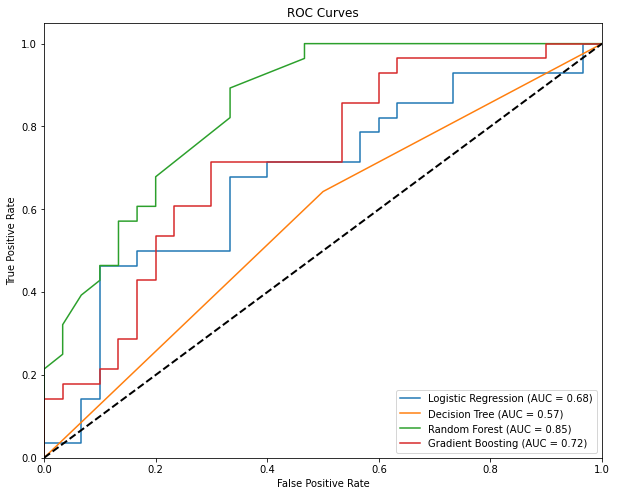

In [251]:
plt.figure(figsize=(10, 8))
for model_name, (fpr, tpr, roc_auc) in roc_curves.items():
    plt.plot(fpr, tpr, label=f'{model_name} (AUC = {roc_auc:.2f})')

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves')
plt.legend(loc="lower right")
plt.show()

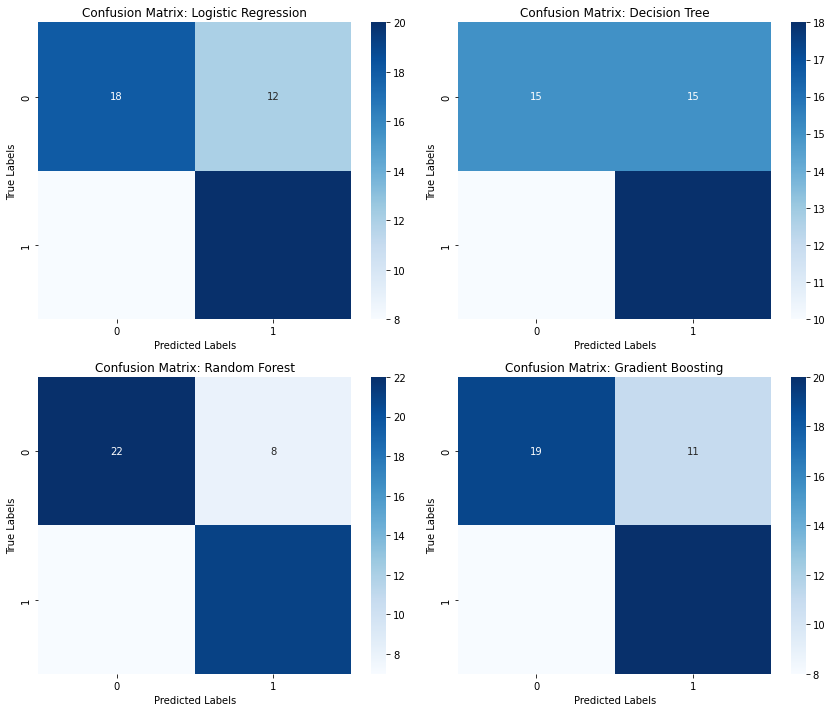

In [252]:
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(12, 10))
axes = axes.flatten()
for ax, (model_name, conf_matrix) in zip(axes, conf_matrices.items()):
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', ax=ax)
    ax.set_title(f'Confusion Matrix: {model_name}')
    ax.set_xlabel('Predicted Labels')
    ax.set_ylabel('True Labels')

plt.tight_layout()
plt.show()

In [253]:
# Display the 10 most important genes for each model
results_table = []
top_n = 10

for name, importance_scores in importances.items():
    model_results = []
    sorted_indices = importance_scores.argsort()[::-1][:top_n]
     
    #Add the 10 most important genes to the model results list
    for i, idx in enumerate(sorted_indices, start=1):
        gene_name = X.columns[idx]  
        importance_score = importance_scores[idx]
        model_results.append([i, gene_name, importance_score])
    
    results_table.append({
        'Model': name,
        'Important Genes': tabulate(model_results, headers=['Position', 'Gene', 'Importance score'], tablefmt='grid')
    })

# Display results in tabular format
for model_result in results_table:
    print(f"Important genes for the model {model_result['Model']}:\n")
    print(model_result['Important Genes'])
    print("\n")

Important genes for the model Logistic Regression:

+------------+-------------+--------------------+
|   Position | Gene        |   Importance score |
+============+=============+====================+
|          1 | LILRB3      |          0.0691273 |
+------------+-------------+--------------------+
|          2 | LOC220594   |          0.0689451 |
+------------+-------------+--------------------+
|          3 | C20orf30    |          0.0596903 |
+------------+-------------+--------------------+
|          4 | AK5         |          0.0583303 |
+------------+-------------+--------------------+
|          5 | ACTR3C      |          0.0569003 |
+------------+-------------+--------------------+
|          6 | PPAN-P2RY11 |          0.0561856 |
+------------+-------------+--------------------+
|          7 | TYW1B       |          0.0554253 |
+------------+-------------+--------------------+
|          8 | STX3        |          0.0542722 |
+------------+-------------+--------------------

In [254]:
# Calculate the average of gene importances across all models
gene_scores = defaultdict(float)

for _, importance_scores in importances.items():
    for idx, score in enumerate(importance_scores):
        gene_scores[idx] += score

for idx, score_sum in gene_scores.items():
    gene_scores[idx] = score_sum / len(importances)

top_genes = sorted(gene_scores.items(), key=lambda x: x[1], reverse=True)[:10]

# Display the top 10 genes with the highest average importance value
print("\nTop 10 Genes with Highest Mean Importance Across All Models:\n")
print(tabulate([(i+1, X.columns[idx], score) for i, (idx, score) in enumerate(top_genes)], headers=['Position', 'Gene', 'Mean Importance Score'], tablefmt='grid'))


Top 10 Genes with Highest Mean Importance Across All Models:

+------------+-----------+-------------------------+
|   Position | Gene      |   Mean Importance Score |
+============+===========+=========================+
|          1 | CCDC78    |               0.0716833 |
+------------+-----------+-------------------------+
|          2 | SGMS1     |               0.0404617 |
+------------+-----------+-------------------------+
|          3 | CTAGE9    |               0.0332497 |
+------------+-----------+-------------------------+
|          4 | ZNF79     |               0.0324854 |
+------------+-----------+-------------------------+
|          5 | C20orf108 |               0.029999  |
+------------+-----------+-------------------------+
|          6 | SMPDL3B   |               0.0295674 |
+------------+-----------+-------------------------+
|          7 | JARID2    |               0.0279435 |
+------------+-----------+-------------------------+
|          8 | TCTN3     |          

In [255]:
# Get a filtered dataset with only the 10 best genes
df_top_genes = numeric_gene[[numeric_gene.columns[0]] + [numeric_gene.columns[idx] for idx, _ in top_genes]]

df_top_genes

,PFI,FPR3,SLC2A10,MEN1,FXYD5,ZMYND12,HOPX,LONRF1,TCTN2,KCNIP2,CD38
83,0,6.2114,11.5478,10.3123,8.0376,5.6672,6.7745,8.6872,9.9759,3.3830,11.0775
295,0,7.2467,9.2117,10.1826,9.0920,6.9337,9.3724,8.2530,8.6977,4.1425,9.2842
526,0,5.1163,10.0566,9.9263,8.5294,6.9378,8.3985,9.7748,9.7084,4.1237,10.2766
40,0,6.6065,10.2109,9.9684,8.5072,6.4059,7.4570,9.8755,9.2538,3.2773,9.7918
50,0,6.6524,11.3709,9.4933,8.0376,6.0655,7.4518,9.5656,9.4847,2.7988,9.4492
...,...,...,...,...,...,...,...,...,...,...,...
523,1,7.2307,10.8414,10.1448,9.1512,5.1478,8.8554,9.1030,9.5084,4.8301,9.1593
524,1,8.3221,10.5078,11.0323,9.9848,6.3880,10.1505,9.6539,8.9966,4.3882,6.2052
532,1,7.0156,10.4315,9.7205,10.0075,6.1384,10.5462,8.8596,9.1131,3.5731,8.1146
535,1,7.4173,10.3507,9.9202,9.8848,5.3930,8.6044,9.2902,9.3891,4.2896,9.5368


Perform the same tests again, but this time with only the top 10 most important genes.

In [256]:
column_chosen = 'PFI'

X_2 = df_top_genes.drop(columns=[column_chosen])
y_2 = df_top_genes[column_chosen] 

In [257]:
print("Feature Set (X):")
print(X_2.head())
print("\nTarget feature (y):")
print(y_2.head())

Feature Set (X):
       FPR3  SLC2A10     MEN1   FXYD5  ZMYND12    HOPX  LONRF1   TCTN2  \
83   6.2114  11.5478  10.3123  8.0376   5.6672  6.7745  8.6872  9.9759   
295  7.2467   9.2117  10.1826  9.0920   6.9337  9.3724  8.2530  8.6977   
526  5.1163  10.0566   9.9263  8.5294   6.9378  8.3985  9.7748  9.7084   
40   6.6065  10.2109   9.9684  8.5072   6.4059  7.4570  9.8755  9.2538   
50   6.6524  11.3709   9.4933  8.0376   6.0655  7.4518  9.5656  9.4847   

     KCNIP2     CD38  
83   3.3830  11.0775  
295  4.1425   9.2842  
526  4.1237  10.2766  
40   3.2773   9.7918  
50   2.7988   9.4492  

Target feature (y):
83     0
295    0
526    0
40     0
50     0
Name: PFI, dtype: int64


In [258]:
# Definition of the models and their parameter grids
models2 = {
    'Logistic Regression': {
        'model': LogisticRegression(),
        'param_grid': {'C': [0.1, 1, 10], 
                       'solver': ['liblinear', 'saga'], 
                       'penalty': ['l1', 'l2']}
    },
    'Decision Tree': {
        'model': DecisionTreeClassifier(),
        'param_grid': {'max_depth': [None, 5, 10], 
                       'criterion': ['gini', 'entropy']}
    },
    'Random Forest': {
        'model': RandomForestClassifier(),
        'param_grid': {'n_estimators': [50, 100, 200], 
                       'max_depth': [None, 10, 20], 
                       'criterion': ['gini', 'entropy']}
    },
    'Gradient Boosting': {
        'model': GradientBoostingClassifier(),
        'param_grid': {'n_estimators': [50, 100, 200], 
                       'learning_rate': [0.01, 0.1, 0.5],
                       'max_depth': [3, 5, 10],
                       'criterion': ['friedman_mse', 'squared_error']}
    }
}

X_train2, X_test, y_train2, y_test = train_test_split(X_2, y_2, test_size=0.3, random_state=42,stratify=y)

best_params_all2 = {}
best_scores_all2 = {}
metrics_all2 = {}
roc_curves2 = {}
conf_matrices2 = {}

In [259]:
# Perform grid search for each model
for model_name, model_data in models2.items():
    print(f"Running GridSearchCV for {model_name}...")
    
    try:
        grid_search = GridSearchCV(model_data['model'], model_data['param_grid'], cv=5, n_jobs=1, verbose=2)
        grid_search.fit(X_train2, y_train2)
        
        # Get the best hyperparameters
        best_params = grid_search.best_params_
        
        # Get the best score
        best_score = grid_search.best_score_
     
        # Store the best hyperparameters and best score for the current model
        best_params_all2[model_name] = best_params
        best_scores_all2[model_name] = best_score

        best_model = grid_search.best_estimator_
        best_model.fit(X_train2, y_train2)
        
        y_pred = best_model.predict(X_test)
        y_proba = best_model.predict_proba(X_test)[:, 1]

        roc_auc = roc_auc_score(y_test, y_proba)
        precision = precision_score(y_test, y_pred)
        recall = recall_score(y_test, y_pred)
        f1 = f1_score(y_test, y_pred)

        metrics_all2[model_name] = {
            'Best Accuracy (GridSearchCV)': best_score,
            'ROC AUC': roc_auc,
            'Precision': precision,
            'Recall': recall,
            'F1 Score': f1
        }

        fpr, tpr, _ = roc_curve(y_test, y_proba)
        roc_curves2[model_name] = (fpr, tpr, roc_auc)
        
        conf_matrix = confusion_matrix(y_test, y_pred)
        conf_matrices2[model_name] = conf_matrix

    except Exception as e:
        print(f"Error occurred for {model_name}: {e}")

Running GridSearchCV for Logistic Regression...
Fitting 5 folds for each of 12 candidates, totalling 60 fits
[CV] END ................C=0.1, penalty=l1, solver=liblinear; total time=   0.0s
[CV] END ................C=0.1, penalty=l1, solver=liblinear; total time=   0.0s
[CV] END ................C=0.1, penalty=l1, solver=liblinear; total time=   0.0s
[CV] END ................C=0.1, penalty=l1, solver=liblinear; total time=   0.0s
[CV] END ................C=0.1, penalty=l1, solver=liblinear; total time=   0.0s
[CV] END .....................C=0.1, penalty=l1, solver=saga; total time=   0.0s
[CV] END .....................C=0.1, penalty=l1, solver=saga; total time=   0.0s
[CV] END .....................C=0.1, penalty=l1, solver=saga; total time=   0.0s
[CV] END .....................C=0.1, penalty=l1, solver=saga; total time=   0.0s
[CV] END .....................C=0.1, penalty=l1, solver=saga; total time=   0.0s
[CV] END ................C=0.1, penalty=l2, solver=liblinear; total time=   0.0s


C:\Users\andre\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\andre\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\andre\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\andre\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\andre\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the 

[CV] END .......................C=1, penalty=l2, solver=saga; total time=   0.0s
[CV] END .......................C=1, penalty=l2, solver=saga; total time=   0.0s
[CV] END .................C=10, penalty=l1, solver=liblinear; total time=   0.0s
[CV] END .................C=10, penalty=l1, solver=liblinear; total time=   0.0s
[CV] END .................C=10, penalty=l1, solver=liblinear; total time=   0.0s
[CV] END .................C=10, penalty=l1, solver=liblinear; total time=   0.0s
[CV] END .................C=10, penalty=l1, solver=liblinear; total time=   0.0s
[CV] END ......................C=10, penalty=l1, solver=saga; total time=   0.0s
[CV] END ......................C=10, penalty=l1, solver=saga; total time=   0.0s
[CV] END ......................C=10, penalty=l1, solver=saga; total time=   0.0s
[CV] END ......................C=10, penalty=l1, solver=saga; total time=   0.0s
[CV] END ......................C=10, penalty=l1, solver=saga; total time=   0.0s
[CV] END .................C=

C:\Users\andre\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\andre\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\andre\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\andre\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\andre\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the 

[CV] END ........................criterion=gini, max_depth=5; total time=   0.0s
[CV] END ........................criterion=gini, max_depth=5; total time=   0.0s
[CV] END ........................criterion=gini, max_depth=5; total time=   0.0s
[CV] END .......................criterion=gini, max_depth=10; total time=   0.0s
[CV] END .......................criterion=gini, max_depth=10; total time=   0.0s
[CV] END .......................criterion=gini, max_depth=10; total time=   0.0s
[CV] END .......................criterion=gini, max_depth=10; total time=   0.0s
[CV] END .......................criterion=gini, max_depth=10; total time=   0.0s
[CV] END ..................criterion=entropy, max_depth=None; total time=   0.0s
[CV] END ..................criterion=entropy, max_depth=None; total time=   0.0s
[CV] END ..................criterion=entropy, max_depth=None; total time=   0.0s
[CV] END ..................criterion=entropy, max_depth=None; total time=   0.0s
[CV] END ..................c

[CV] END ...criterion=entropy, max_depth=20, n_estimators=50; total time=   0.0s
[CV] END ...criterion=entropy, max_depth=20, n_estimators=50; total time=   0.0s
[CV] END ..criterion=entropy, max_depth=20, n_estimators=100; total time=   0.0s
[CV] END ..criterion=entropy, max_depth=20, n_estimators=100; total time=   0.0s
[CV] END ..criterion=entropy, max_depth=20, n_estimators=100; total time=   0.0s
[CV] END ..criterion=entropy, max_depth=20, n_estimators=100; total time=   0.0s
[CV] END ..criterion=entropy, max_depth=20, n_estimators=100; total time=   0.0s
[CV] END ..criterion=entropy, max_depth=20, n_estimators=200; total time=   0.2s
[CV] END ..criterion=entropy, max_depth=20, n_estimators=200; total time=   0.2s
[CV] END ..criterion=entropy, max_depth=20, n_estimators=200; total time=   0.2s
[CV] END ..criterion=entropy, max_depth=20, n_estimators=200; total time=   0.1s
[CV] END ..criterion=entropy, max_depth=20, n_estimators=200; total time=   0.1s
Running GridSearchCV for Gra

[CV] END criterion=friedman_mse, learning_rate=0.1, max_depth=5, n_estimators=200; total time=   0.3s
[CV] END criterion=friedman_mse, learning_rate=0.1, max_depth=5, n_estimators=200; total time=   0.3s
[CV] END criterion=friedman_mse, learning_rate=0.1, max_depth=5, n_estimators=200; total time=   0.3s
[CV] END criterion=friedman_mse, learning_rate=0.1, max_depth=5, n_estimators=200; total time=   0.4s
[CV] END criterion=friedman_mse, learning_rate=0.1, max_depth=5, n_estimators=200; total time=   0.4s
[CV] END criterion=friedman_mse, learning_rate=0.1, max_depth=10, n_estimators=50; total time=   0.0s
[CV] END criterion=friedman_mse, learning_rate=0.1, max_depth=10, n_estimators=50; total time=   0.0s
[CV] END criterion=friedman_mse, learning_rate=0.1, max_depth=10, n_estimators=50; total time=   0.0s
[CV] END criterion=friedman_mse, learning_rate=0.1, max_depth=10, n_estimators=50; total time=   0.1s
[CV] END criterion=friedman_mse, learning_rate=0.1, max_depth=10, n_estimators=50;

[CV] END criterion=squared_error, learning_rate=0.01, max_depth=5, n_estimators=50; total time=   0.0s
[CV] END criterion=squared_error, learning_rate=0.01, max_depth=5, n_estimators=50; total time=   0.0s
[CV] END criterion=squared_error, learning_rate=0.01, max_depth=5, n_estimators=50; total time=   0.0s
[CV] END criterion=squared_error, learning_rate=0.01, max_depth=5, n_estimators=50; total time=   0.0s
[CV] END criterion=squared_error, learning_rate=0.01, max_depth=5, n_estimators=100; total time=   0.1s
[CV] END criterion=squared_error, learning_rate=0.01, max_depth=5, n_estimators=100; total time=   0.1s
[CV] END criterion=squared_error, learning_rate=0.01, max_depth=5, n_estimators=100; total time=   0.1s
[CV] END criterion=squared_error, learning_rate=0.01, max_depth=5, n_estimators=100; total time=   0.2s
[CV] END criterion=squared_error, learning_rate=0.01, max_depth=5, n_estimators=100; total time=   0.1s
[CV] END criterion=squared_error, learning_rate=0.01, max_depth=5, n

[CV] END criterion=squared_error, learning_rate=0.5, max_depth=3, n_estimators=100; total time=   0.0s
[CV] END criterion=squared_error, learning_rate=0.5, max_depth=3, n_estimators=100; total time=   0.0s
[CV] END criterion=squared_error, learning_rate=0.5, max_depth=3, n_estimators=100; total time=   0.0s
[CV] END criterion=squared_error, learning_rate=0.5, max_depth=3, n_estimators=200; total time=   0.2s
[CV] END criterion=squared_error, learning_rate=0.5, max_depth=3, n_estimators=200; total time=   0.2s
[CV] END criterion=squared_error, learning_rate=0.5, max_depth=3, n_estimators=200; total time=   0.2s
[CV] END criterion=squared_error, learning_rate=0.5, max_depth=3, n_estimators=200; total time=   0.2s
[CV] END criterion=squared_error, learning_rate=0.5, max_depth=3, n_estimators=200; total time=   0.2s
[CV] END criterion=squared_error, learning_rate=0.5, max_depth=5, n_estimators=50; total time=   0.0s
[CV] END criterion=squared_error, learning_rate=0.5, max_depth=5, n_estima

In [260]:
results2 = []
for model_name in best_params_all2.keys():
    result2 = {
        'Model': model_name,
        'Best Params': best_params_all2[model_name],
        'Best Accuracy': metrics_all2[model_name]['Best Accuracy (GridSearchCV)'],
        'ROC AUC': metrics_all2[model_name]['ROC AUC'],
        'Precision': metrics_all2[model_name]['Precision'],
        'Recall': metrics_all2[model_name]['Recall'],
        'F1 Score': metrics_all2[model_name]['F1 Score']
    }
    results2.append(result2)

results_df2 = pd.DataFrame(results2)

results2_dict = {row['Model']: row.drop('Model').to_dict() for _, row in results_df2.iterrows()}

results_df2

,Model,Best Params,Best Accuracy,ROC AUC,Precision,Recall,F1 Score
0,Logistic Regression,"{'C': 1, 'penalty': 'l1', 'solver': 'liblinear'}",0.666667,0.711905,0.653846,0.607143,0.629630
1,Decision Tree,"{'criterion': 'gini', 'max_depth': 5}",0.585185,0.681548,0.681818,0.535714,0.600000
2,Random Forest,"{'criterion': 'gini', 'max_depth': None, 'n_es...",0.674074,0.751786,0.655172,0.678571,0.666667
3,Gradient Boosting,"{'criterion': 'squared_error', 'learning_rate'...",0.651852,0.790476,0.720000,0.642857,0.679245


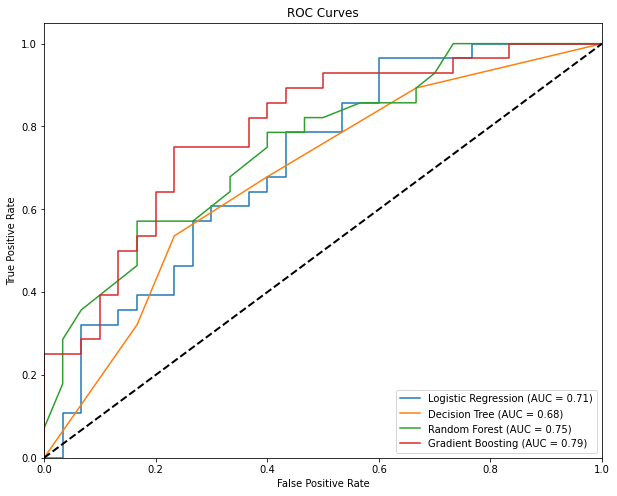

In [261]:
plt.figure(figsize=(10, 8))
for model_name, (fpr, tpr, roc_auc) in roc_curves2.items():
    plt.plot(fpr, tpr, label=f'{model_name} (AUC = {roc_auc:.2f})')

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves')
plt.legend(loc="lower right")
plt.show()

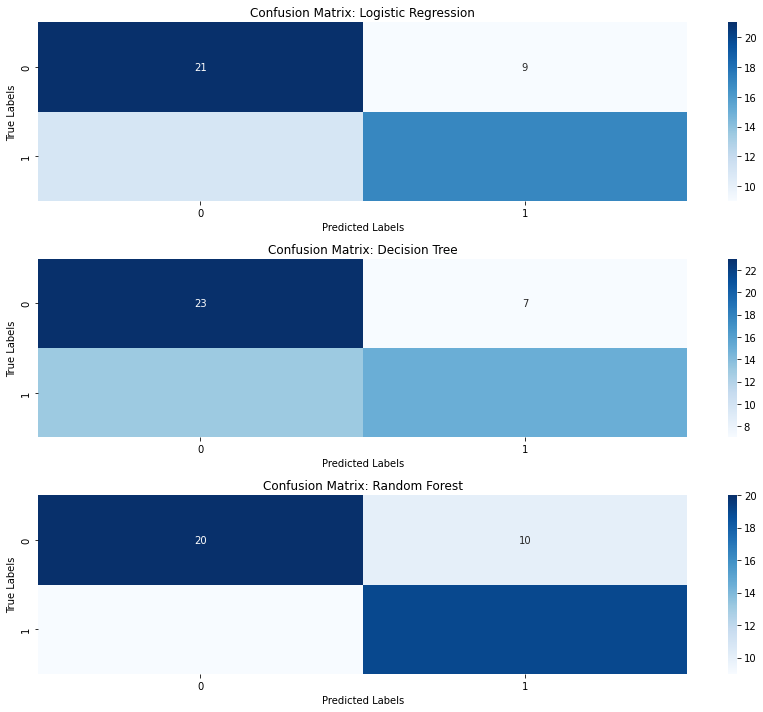

In [262]:
fig, axes = plt.subplots(nrows=3, ncols=1, figsize=(12, 10))
axes = axes.flatten()
for ax, (model_name, conf_matrix) in zip(axes, conf_matrices2.items()):
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', ax=ax)
    ax.set_title(f'Confusion Matrix: {model_name}')
    ax.set_xlabel('Predicted Labels')
    ax.set_ylabel('True Labels')

plt.tight_layout()
plt.show()

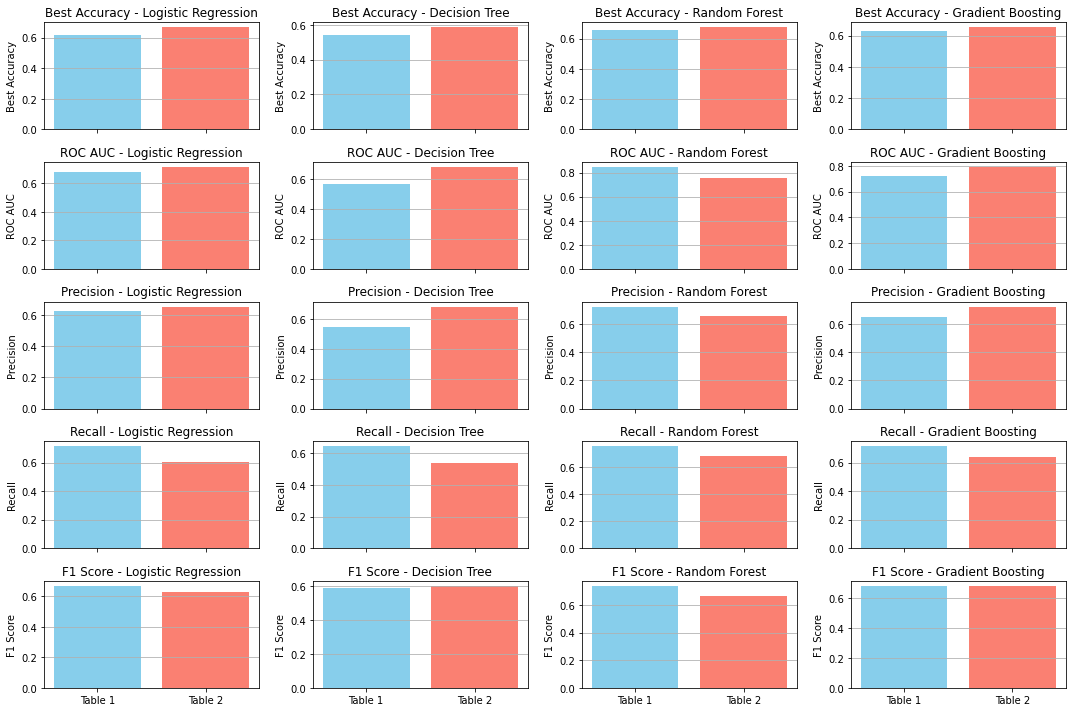

In [263]:
# Ensuring that results_dict and results2_dict are dictionaries
results_dict = {row['Model']: row.drop('Model').to_dict() for _, row in results_df.iterrows()}
results2_dict = {row['Model']: row.drop('Model').to_dict() for _, row in results_df2.iterrows()}

model_names = results2_dict.keys()
metrics = ['Best Accuracy', 'ROC AUC', 'Precision', 'Recall', 'F1 Score']

fig, ax = plt.subplots(len(metrics), len(model_names), figsize=(15, 10), sharex=True)

colors = {'Table 1': 'skyblue', 'Table 2': 'salmon'}

for i, metric in enumerate(metrics):
    for j, model_name in enumerate(model_names):
        result_ = results_dict[model_name]
        result2_ = results2_dict[model_name]
        
        value = result_[metric]
        value2 = result2_[metric]
        
        ax[i, j].bar(['Table 1', 'Table 2'], [value, value2], color=[colors['Table 1'], colors['Table 2']])
        ax[i, j].set_title(f'{metric} - {model_name}')
        ax[i, j].set_ylabel(metric)
        ax[i, j].grid(axis='y')

plt.tight_layout()
plt.show()

In [264]:
# Get a dataset filtered with only the 10 best genes
top_genes_sampled = merged_sampled[[merged_sampled.columns[i] for i in range (11)] +
                                   [numeric_gene.columns[idx] for idx, _ in top_genes]]

top_genes_sampled

,sample,ID,Ctype,Tissue,Stage,OS,OS.time,PFI,PFI.time,Age,...,FPR3,SLC2A10,MEN1,FXYD5,ZMYND12,HOPX,LONRF1,TCTN2,KCNIP2,CD38
83,TCGA-EJ-7123-01,TCGA-EJ-7123,PRAD,TP,T1,0,85.73,0,85.73,59.0,...,6.2114,11.5478,10.3123,8.0376,5.6672,6.7745,8.6872,9.9759,3.3830,11.0775
295,TCGA-HC-A6AO-01,TCGA-HC-A6AO,PRAD,TP,T1,0,17.67,0,17.67,52.0,...,7.2467,9.2117,10.1826,9.0920,6.9337,9.3724,8.2530,8.6977,4.1425,9.2842
526,TCGA-ZG-A8QX-01,TCGA-ZG-A8QX,PRAD,TP,T1,0,14.73,0,14.73,56.0,...,5.1163,10.0566,9.9263,8.5294,6.9378,8.3985,9.7748,9.7084,4.1237,10.2766
40,TCGA-CH-5772-01,TCGA-CH-5772,PRAD,TP,NaN,0,16.20,0,16.20,63.0,...,6.6065,10.2109,9.9684,8.5072,6.4059,7.4570,9.8755,9.2538,3.2773,9.7918
50,TCGA-EJ-5497-01,TCGA-EJ-5497,PRAD,TP,T2,0,13.50,0,13.50,47.0,...,6.6524,11.3709,9.4933,8.0376,6.0655,7.4518,9.5656,9.4847,2.7988,9.4492
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
523,TCGA-YL-A9WX-01,TCGA-YL-A9WX,PRAD,TP,T3,0,50.60,1,50.20,68.0,...,7.2307,10.8414,10.1448,9.1512,5.1478,8.8554,9.1030,9.5084,4.8301,9.1593
524,TCGA-YL-A9WY-01,TCGA-YL-A9WY,PRAD,TP,T3,0,36.60,1,25.50,57.0,...,8.3221,10.5078,11.0323,9.9848,6.3880,10.1505,9.6539,8.9966,4.3882,6.2052
532,TCGA-ZG-A9L2-01,TCGA-ZG-A9L2,PRAD,TP,T3,0,38.47,1,6.00,70.0,...,7.0156,10.4315,9.7205,10.0075,6.1384,10.5462,8.8596,9.1131,3.5731,8.1146
535,TCGA-ZG-A9L6-01,TCGA-ZG-A9L6,PRAD,TP,T1,0,22.90,1,22.13,64.0,...,7.4173,10.3507,9.9202,9.8848,5.3930,8.6044,9.2902,9.3891,4.2896,9.5368


In [265]:
# Identify the numeric columns
numeric_columns2 = top_genes_sampled.select_dtypes(include=['float64', 'int64']).columns

# Creating a new dataset with only numeric columns
cox_hazard = top_genes_sampled[numeric_columns2]

# List of columns to remove
colunas_patologicas2 = ['OS.time','OS', 'Age']

# Create a new dataset removing this columns
cox_hazard = cox_hazard.drop(columns=colunas_patologicas2)

In [266]:
cox_hazard

,PFI,PFI.time,FPR3,SLC2A10,MEN1,FXYD5,ZMYND12,HOPX,LONRF1,TCTN2,KCNIP2,CD38
83,0,85.73,6.2114,11.5478,10.3123,8.0376,5.6672,6.7745,8.6872,9.9759,3.3830,11.0775
295,0,17.67,7.2467,9.2117,10.1826,9.0920,6.9337,9.3724,8.2530,8.6977,4.1425,9.2842
526,0,14.73,5.1163,10.0566,9.9263,8.5294,6.9378,8.3985,9.7748,9.7084,4.1237,10.2766
40,0,16.20,6.6065,10.2109,9.9684,8.5072,6.4059,7.4570,9.8755,9.2538,3.2773,9.7918
50,0,13.50,6.6524,11.3709,9.4933,8.0376,6.0655,7.4518,9.5656,9.4847,2.7988,9.4492
...,...,...,...,...,...,...,...,...,...,...,...,...
523,1,50.20,7.2307,10.8414,10.1448,9.1512,5.1478,8.8554,9.1030,9.5084,4.8301,9.1593
524,1,25.50,8.3221,10.5078,11.0323,9.9848,6.3880,10.1505,9.6539,8.9966,4.3882,6.2052
532,1,6.00,7.0156,10.4315,9.7205,10.0075,6.1384,10.5462,8.8596,9.1131,3.5731,8.1146
535,1,22.13,7.4173,10.3507,9.9202,9.8848,5.3930,8.6044,9.2902,9.3891,4.2896,9.5368


In [380]:
cph = CoxPHFitter()
cph.fit(cox_hazard, duration_col='PFI.time', event_col='PFI')

summary = cph.summary
summary

,coef,exp(coef),se(coef),coef lower 95%,coef upper 95%,exp(coef) lower 95%,exp(coef) upper 95%,cmp to,z,p,-log2(p)
covariate,,,,,,,,,,,
FPR3,0.405741,1.500414,0.144676,0.122182,0.689300,1.129960,1.992321,0.0,2.804486,0.005040,7.632448
SLC2A10,-0.120221,0.886725,0.127176,-0.369480,0.129039,0.691093,1.137734,0.0,-0.945313,0.344499,1.537427
MEN1,0.840416,2.317331,0.340349,0.173345,1.507487,1.189276,4.515370,0.0,2.469280,0.013539,6.206787
FXYD5,-0.231161,0.793611,0.184020,-0.591834,0.129512,0.553311,1.138272,0.0,-1.256173,0.209053,2.258059
ZMYND12,-0.159548,0.852529,0.135685,-0.425486,0.106390,0.653452,1.112256,0.0,-1.175867,0.239648,2.061012
HOPX,0.303398,1.354454,0.140617,0.027795,0.579002,1.028184,1.784257,0.0,2.157626,0.030957,5.013594
LONRF1,-0.313832,0.730642,0.152770,-0.613255,-0.014409,0.541585,0.985694,0.0,-2.054281,0.039948,4.645716
TCTN2,-0.127334,0.880440,0.202009,-0.523264,0.268597,0.592583,1.308128,0.0,-0.630336,0.528474,0.920094
KCNIP2,0.376286,1.456864,0.153075,0.076266,0.676307,1.079249,1.966601,0.0,2.458189,0.013964,6.162149


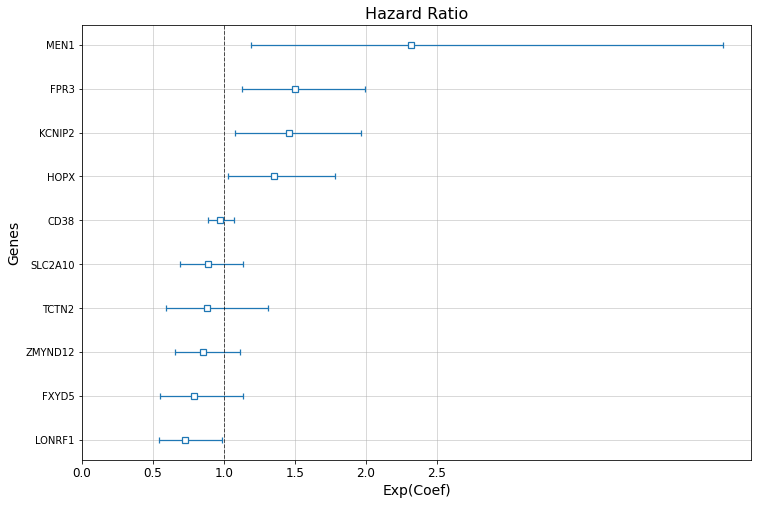

In [387]:
plt.figure(figsize=(12, 8))

cph.plot(hazard_ratios=True, c='#1f77b4', linewidth=2)

plt.title('Hazard Ratio', fontsize=16)
plt.ylabel('Genes', fontsize=14)
plt.xlabel('Exp(Coef)', fontsize=14)

exp_coef_values = cph.summary['exp(coef)']
plt.xticks(ticks=np.arange(0, max(exp_coef_values) + 0.5, 0.5), fontsize=12)

plt.grid(True, linestyle='-', alpha=0.6)

plt.show()


Optimal Cutoff: 12.539126870157567
Low Risk Group size: 97
High Risk Group size: 96


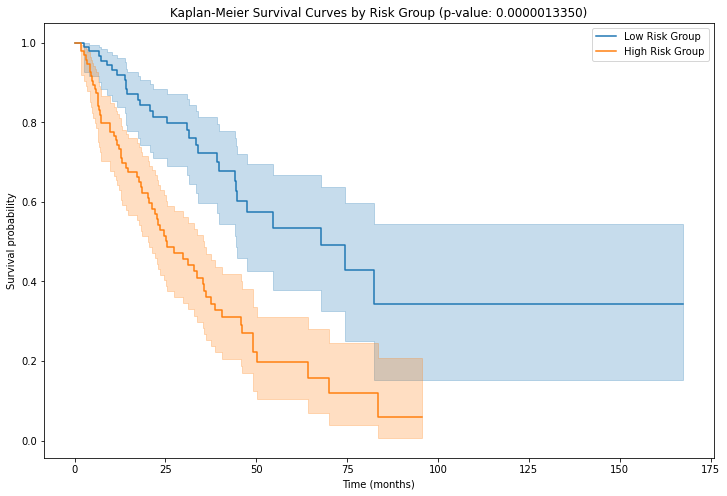

In [337]:
genes = top_genes_sampled.iloc[:, -10:].astype(float)

# Coefficients obtained from the Cox model
coeficientes = cph.summary['coef']

# Extract genes with p-value < 0.05
significant_genes = genes.columns[cph.summary['p'] < 0.05]
filtered_genes = genes[significant_genes]

# Initialize risk_scores array
risk_scores = np.zeros(filtered_genes.shape[0])  # Number of patients

# Calculate risk_scores for each patient by multiplying gene values by coefficients
for gene in filtered_genes.columns:
    if gene in coeficientes.index:
        risk_scores += filtered_genes[gene] * coeficientes[gene]

# Finding the optimal cutoff
optimal_cutoff = np.median(risk_scores)
print('Optimal Cutoff:', optimal_cutoff)

# Separate patients into two groups based on the optimal cutoff
low_risk_group = top_genes_sampled[risk_scores <= optimal_cutoff]
high_risk_group = top_genes_sampled[risk_scores > optimal_cutoff]
print('Low Risk Group size:', len(low_risk_group))
print('High Risk Group size:', len(high_risk_group))

kmf_low_risk = KaplanMeierFitter()
kmf_high_risk = KaplanMeierFitter()

kmf_low_risk.fit(low_risk_group['PFI.time'], event_observed=low_risk_group['PFI'])
kmf_high_risk.fit(high_risk_group['PFI.time'], event_observed=high_risk_group['PFI'])

# Calculate the logrank test between the two groups
results = logrank_test(low_risk_group['PFI.time'], high_risk_group['PFI.time'], event_observed_A=low_risk_group['PFI'], event_observed_B=high_risk_group['PFI'])

plt.figure(figsize=(12, 8))
kmf_low_risk.plot(label='Low Risk Group')
kmf_high_risk.plot(label='High Risk Group')

plt.xlabel('Time (months)')
plt.ylabel('Survival probability')
plt.title(f'Kaplan-Meier Survival Curves by Risk Group (p-value: {results.p_value:.10f})')
plt.legend()
plt.show()

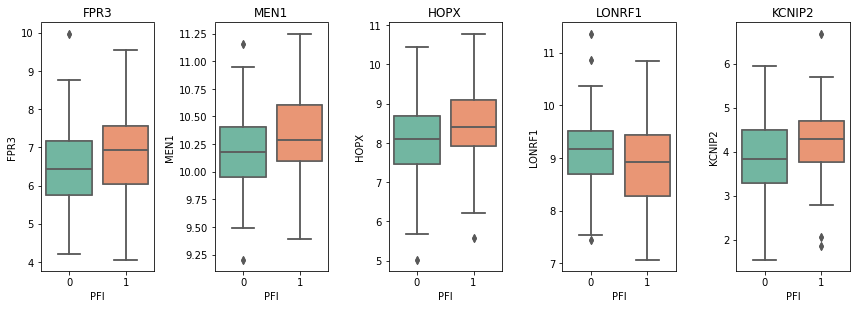

In [312]:
genes = df_top_genes.columns[-10:]

plt.figure(figsize=(12, 8))

for i, gene in enumerate(filtered_genes, start=1):
    plt.subplot(2, 5, i)
    
    # Boxplot for PFI = 0
    sns.boxplot(x='PFI', y=gene, data=df_top_genes, palette='Set3')
    plt.title(f'{gene}')
    
    # Boxplot for PFI = 1
    sns.boxplot(x='PFI', y=gene, data=df_top_genes, palette='Set2')
    plt.title(f'{gene}')

plt.tight_layout()
plt.show()

<Figure size 864x576 with 0 Axes>

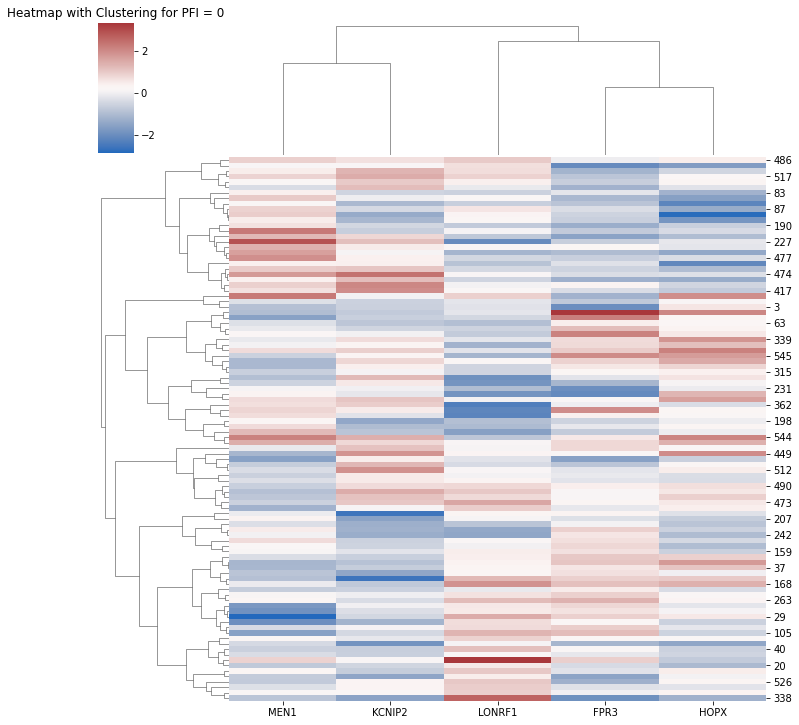

<Figure size 864x576 with 0 Axes>

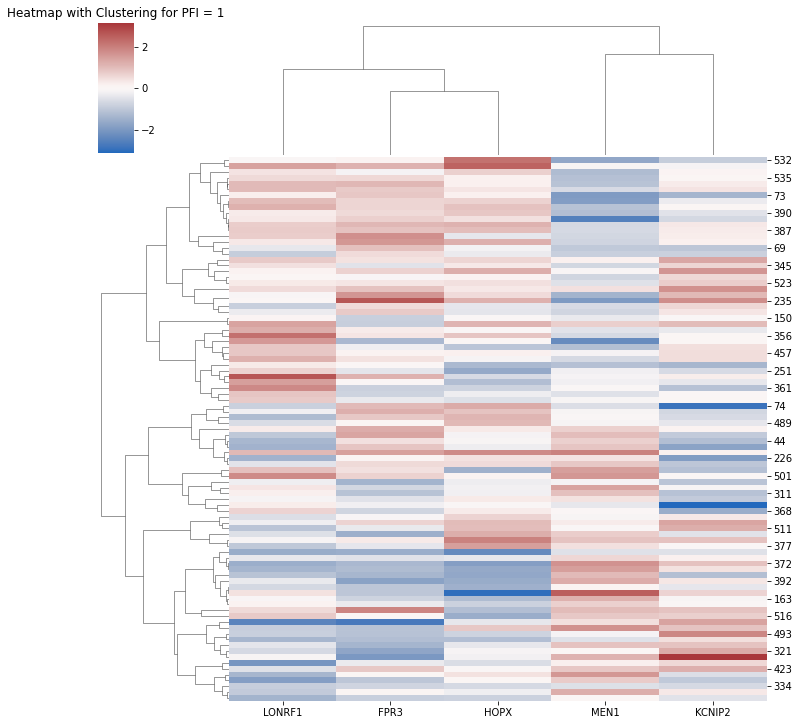

In [338]:
significant_genes = top_genes_sampled.iloc[:, -10:].columns[cph.summary['p'] < 0.05]

data_pfi_0 = X_pfi_0_scaled[significant_genes]
data_pfi_1 = X_pfi_1_scaled[significant_genes]

def plot_heatmap(data, title):
    plt.figure(figsize=(12, 8))
    sns.clustermap(data, cmap='vlag', metric='correlation', method='average')
    plt.title(title)
    plt.show()

plot_heatmap(data_pfi_0, 'Heatmap with Clustering for PFI = 0')

plot_heatmap(data_pfi_1, 'Heatmap with Clustering for PFI = 1')
